# 0.0 Imports

## 0.1 Libraries

In [1]:
import inflection           as inf
import math
import matplotlib.pyplot    as plt
import numpy                as np 
import pandas               as pd
import pickle               as pi
import seaborn              as sns
from  scipy.stats          import pointbiserialr 
from  scipy                import stats as ss
import warnings

from IPython.core.display import HTML
from IPython.display      import Image


# Machine Learning Models
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import BernoulliNB
from sklearn.preprocessing import MinMaxScaler, RobustScaler , LabelEncoder



# Model evalution
from sklearn.calibration     import CalibratedClassifierCV
from sklearn.calibration     import calibration_curve
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics         import classification_report, cohen_kappa_score, make_scorer
from sklearn.metrics         import precision_recall_fscore_support, confusion_matrix, f1_score, roc_curve
from sklearn.metrics         import roc_auc_score, accuracy_score, cohen_kappa_score
from sklearn.metrics         import precision_recall_curve
from sklearn.metrics         import precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV

from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain

warnings.filterwarnings('ignore')

## 0.2 Helper Function

In [2]:
# Settings Style
sns.set_style('whitegrid')
sns.color_palette("light:b", as_cmap=True)

# Set to display an unlimited number of columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Setting title and labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

<h4> Cramer V </h4>

In [3]:
def cramer_v(var_x, var_y):
    
    # Contigency matrix
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # sum of all the matrix values
    n = confusion_matrix.sum()
    
    # rols, cols
    r, k = confusion_matrix.shape
    
    # chi-squared
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    
    # Correction Bias
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # Return Cramer V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

<h4> Descriptive Statistics </h4>

In [4]:
def descriptive_statistics(num_var):

    # Central Tendency
    ct1 = pd.DataFrame(num_var.apply(np.mean)).T
    ct2 = pd.DataFrame(num_var.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_var.apply(np.std)).T
    d2 = pd.DataFrame(num_var.apply(min)).T
    d3 = pd.DataFrame(num_var.apply(max)).T
    d4 = pd.DataFrame(num_var.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_var.apply(lambda x: x.skew() ) ).T
    d6 = pd.DataFrame(num_var.apply(lambda x: x.kurtosis())).T

    # Concatenation of analyses
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['variable', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    # Summary of statistics
    return m

<h4> Model Performance Function </h4>

In [5]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               }

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

<h4> Performance Test Function </h4>

In [6]:
def performance_test(model_name, model, x_test, y_test):
    # predictions
    y_hat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    f1 = f1_score(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat)
    
    # Peformance dataframe
    performance_df = pd.DataFrame({'Precision': precision,
                                   'Recall': recall,
                                   'F1-Score': f1,
                                   'ROC AUC Score': roc_auc}, index=[model_name])
        # confusion matrix
    cm = confusion_matrix(y_test, y_hat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted not churn', 'predicted churn'], 
                         index=['actual not churn', 'actual churn'])
    
    return performance_df, cm_df

## 0.3 Data Dicionary

 - **RowNumber:** Number of the column.
 
 - **CustomerID:** Unique customer identifier.
 
 - **Surname:** Customer's last name.
 
 - **CreditScore:** The customer's Credit score for the consumer market.
 
 - **Geography:** The country where the client resides.
 
 - **Gender:** The gender of the customer.
 
 - **Age:** The customer's age.
 
 - **Tenure:** Number of months that the customer remained active.
 
 - **Balance:** Monetary value that the customer has in his bank account.
 
 - **NumOfProducts:** The number of products purchased by the customer at the bank.
 
 - **HasCrCard:** Indicates whether or not the customer has a credit card.
 
 - **IsActiveMember:** Indicates if the customer made at least one movement in the bank account within 12 months.
 
 - **EstimateSalary:** Estimate of the customer's annual salary.
 
 - **Exited:** Indicates if the customer is in Churn or not.

## 0.4 Loading Data

### 0.4.1 Loading Original Data

In [7]:
df = pd.read_csv('C:/Users/diasn/projeto_aluno/pa003/data/churn.csv')
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

### 0.4.2 Split Data into Train and Test Set

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Observations:**

- The dataset has 10000 entries and 14 columns.
- Low memory usage: 1.1 MB.
- There are no missing values.

In [9]:
# Checking Exited proportion
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
# Apply Statified sampling in order to keep target variable proportion in the train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['Exited']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [12]:
# Checking Exited proportion on train set
train_set['Exited'].value_counts(normalize=True)

0    0.79625
1    0.20375
Name: Exited, dtype: float64

In [13]:
# Checking Exited proportion on test set
test_set['Exited'].value_counts(normalize=True)

0    0.7965
1    0.2035
Name: Exited, dtype: float64

### 0.4.3 Save Data Sets

In [14]:
train_set.to_csv('C:/Users/diasn/projeto_aluno/pa003_churn_predict/data/train_churn')

In [15]:
test_set.to_csv('C:/Users/diasn/projeto_aluno/pa003_churn_predict/data/test_churn')

# 1.0 Data Descriptions

To begin with, let's famiTo begin with, let's familiarize ourselves with the data set by describing the data, that is, let's explore the characteristics of the data and work with the following topics:

- Rename Columns
- Data Dimensions
- Data Type
- Checking Missing Data
- Data Changes
- Descriptive Statistics

However, before proceeding, at each stage completed, we will make a copy of the data set so as not to lose what has already been done. This procedure makes the work much easier in case something goes wrong with the code.

In [16]:
# Salving a copy of the dataset
df1 = pd.read_csv('C:/Users/diasn/projeto_aluno/pa003_churn_predict/data/train_churn')

In [17]:
# Viewing dataset
df1.head()

Unnamed: 0  RowNumber  CustomerId   Surname  CreditScore Geography  Gender  \
0        2151       2152    15588614    Walton          753    France    Male   
1        8392       8393    15641158   Belcher          739   Germany    Male   
2        5006       5007    15750014   Chikere          755   Germany  Female   
3        4117       4118    15663964  Pagnotto          561    France    Male   
4        7182       7183    15573520    Rhodes          692   Germany    Male   

   Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0   57       7       0.00              1          1               0   
1   32       3  102128.27              1          1               0   
2   37       0  113865.23              2          1               1   
3   37       5       0.00              2          1               0   
4   49       6  110540.43              2          0               1   

   EstimatedSalary  Exited  
0        159475.08       1  
1         63981.37       1  
2        117396.25       0  
3         83093.25       0  
4        107472.99       0

## 1.1 Rename Columns

The first step that we will do is to rename the columns of the data set.

In [18]:
df1 = df1.drop(['Unnamed: 0'], axis=1)

In [19]:
df1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [20]:
# List Columns
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
            'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inf.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [21]:
# Viewing the data
df1.head()

row_number  customer_id   surname  credit_score geography  gender  age  \
0        2152     15588614    Walton           753    France    Male   57   
1        8393     15641158   Belcher           739   Germany    Male   32   
2        5007     15750014   Chikere           755   Germany  Female   37   
3        4118     15663964  Pagnotto           561    France    Male   37   
4        7183     15573520    Rhodes           692   Germany    Male   49   

   tenure    balance  num_of_products  has_cr_card  is_active_member  \
0       7       0.00                1            1                 0   
1       3  102128.27                1            1                 0   
2       0  113865.23                2            1                 1   
3       5       0.00                2            1                 0   
4       6  110540.43                2            0                 1   

   estimated_salary  exited  
0         159475.08       1  
1          63981.37       1  
2         117396.25       0  
3          83093.25       0  
4         107472.99       0

## 1.2 Data Dimensions

The second step that we will make is to find the dimensions of the data set, that is, the number of rows and number of cols.

In [22]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns : {df1.shape[1]}')

Number of Rows: 8000
Number of Columns : 14


Looking at the records above, the data set has about 8000 customers with 14 characteristics each. It is not a large data set that requires the use of any **server or cloud**.

## 1.3 Data Type

The third step to consider is about the types of data we are dealing with, because it is of fundamental importance to know the aspect of each one of them.

In [23]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check Missing Data

The next treatment that we will make is to check the missing data. It is important to fill in all the missing data in the data set to decrease the data bias.

Usually some techniques are used to fill this data, such as the average, the median or even some solution thinking about the business issue.

In [24]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

We can see that the data set has no missing data.

## 1.5 Data Changes

In this section, we will rename the binary (categorical) data that are represented by numbers according to the data dictionary. Therefore, the data will be transformed into objects.

In [25]:
# has_cr_card
df1['has_cr_card'] = df1['has_cr_card'].apply(lambda x: 'yes' if x==1 else 'no')

# is_active_number
df1['is_active_member'] = df1['is_active_member'].apply(lambda x: 'yes' if x==1 else 'no')

# exited
df1['exited'] = df1['exited'].apply(lambda x: 'yes' if x==1 else 'no')

In [26]:
# Checking data
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card          object
is_active_member     object
estimated_salary    float64
exited               object
dtype: object

We can see above that the data was transformed as we wanted.

## 1.6 Descriptive Statistics 

Descriptive Statistics is the area that aims to **summarize and describe any set of data**. In other words, it is that statistic that is concerned with synthesizing the data in a direct way, worrying about fewer variations and confidence intervals of the data. Therefore, at this stage, what we will do is to understand the characteristics of the data through this analysis.

Let's start by separating the variables between numerical and categorical.

In [27]:
# numerical variables
num_var = df1.select_dtypes(include= ['int64', 'float64'])

# categorical variables
cat_var = df1.select_dtypes(exclude= ['int64', 'float64'])

### 1.6.1 Numerical Variables

In [28]:
descriptive_statistics(num_var)

variable          min          max      range          mean  \
0        row_number         1.00     10000.00    9999.00  4.990433e+03   
1       customer_id  15565701.00  15815690.00  249989.00  1.569088e+07   
2      credit_score       350.00       850.00     500.00  6.507525e+02   
3               age        18.00        92.00      74.00  3.894662e+01   
4            tenure         0.00        10.00      10.00  5.016625e+00   
5           balance         0.00    238387.56  238387.56  7.638121e+04   
6   num_of_products         1.00         4.00       3.00  1.529500e+00   
7  estimated_salary        11.58    199992.48  199980.90  9.973081e+04   

         median           std      skew  kurtosis  
0  4.987500e+03   2896.301295  0.002629 -1.209629  
1  1.568995e+07  71931.689685  0.006936 -1.196055  
2  6.520000e+02     96.590394 -0.079540 -0.418624  
3  3.700000e+01     10.526219  1.035706  1.459448  
4  5.000000e+00      2.896610  0.013124 -1.172842  
5  9.705515e+04  62298.159597 -0.141721 -1.492209  
6  1.000000e+00      0.581704  0.755984  0.636943  
7  9.944694e+04  57331.532983  0.007126 -1.174789

**Relavants Observations:**

- The average credit for consumption is 650,75 euros.
- The average age of the bank's clients is 38.94 years.
- The average number of months that customers remained active is 5 months.
- The average balance of the customers' account is 76.381,21 euros.
- The average number of products purchased by the bank's clients is 1.53.
- The minimum estimated salary of some people is 11.58 euros. This result is suspect compared to the average estimated salary of 99.730,08 euros.

<h3> Checking Outliers </h3>

#### 1.6.1.1 Checking Age

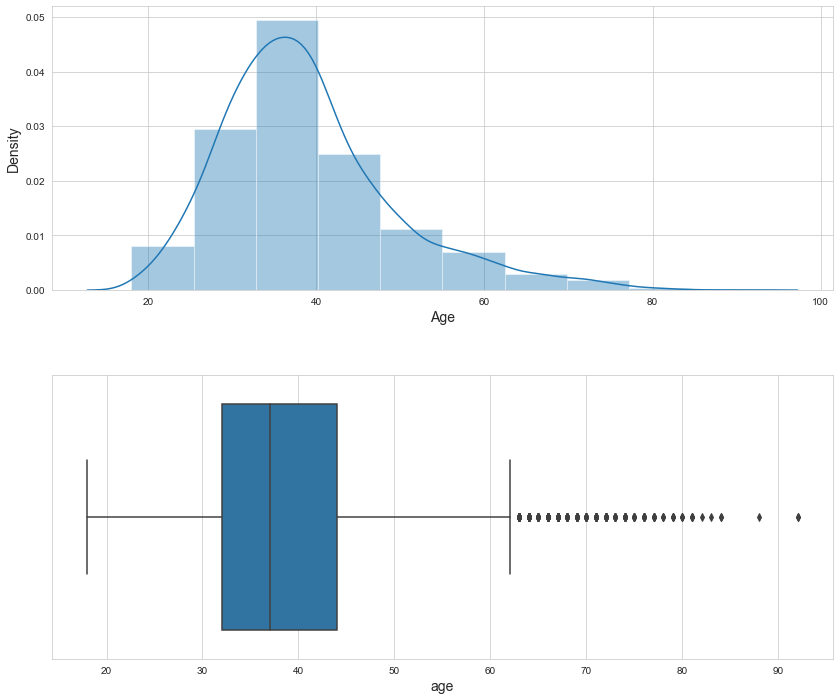

Age boundaries for outliers:
Q1 = 32.0
Q3 = 44.0
IQR = 12.0
low_outliers = 14.0
high_outliers = 62.0


In [29]:
figure, gr = plt.subplots()

gr.figure.set_size_inches(14,12)

plt.subplot(2,1,1)
gr = sns.distplot(df1['age'], bins=10)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
gr = sns.boxplot(df1['age'])
plt.xlabel('age', fontsize=14)
plt.show()

# Calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['age'], 0.25)
Q3 = np.quantile(df1['age'], 0.75)
IQR = Q3 - Q1

# Calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print('Age boundaries for outliers:')
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

**Observation:**

- We can observe that the ages are characterized as outliers over 62.

#### 1.6.1.2 Checking Credit Score

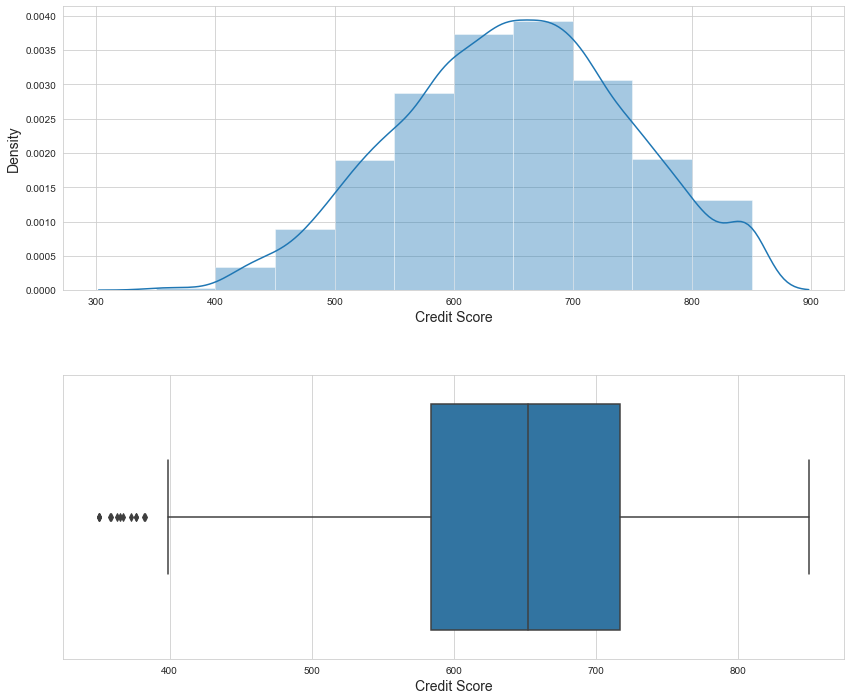

Credit Score boundaries for outliers:
Q1 = 584.0
Q3 = 717.0
IQR = 133.0
low_outliers = 384.5
high_outliers = 916.5


In [30]:
figure, gr = plt.subplots()

gr.figure.set_size_inches(14,12)

plt.subplot(2,1,1)
gr = sns.distplot(df1['credit_score'], bins=10)
plt.xlabel('Credit Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
gr = sns.boxplot(df1['credit_score'])
plt.xlabel('Credit Score', fontsize=14)
plt.show()

# Calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['credit_score'], 0.25)
Q3 = np.quantile(df1['credit_score'], 0.75)
IQR = Q3 - Q1

# Calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print('Credit Score boundaries for outliers:')
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

**Observation:**

- We can observe that the credit score is characterized with outliers below 384.5.

#### 1.6.1.3 Checking Tenure

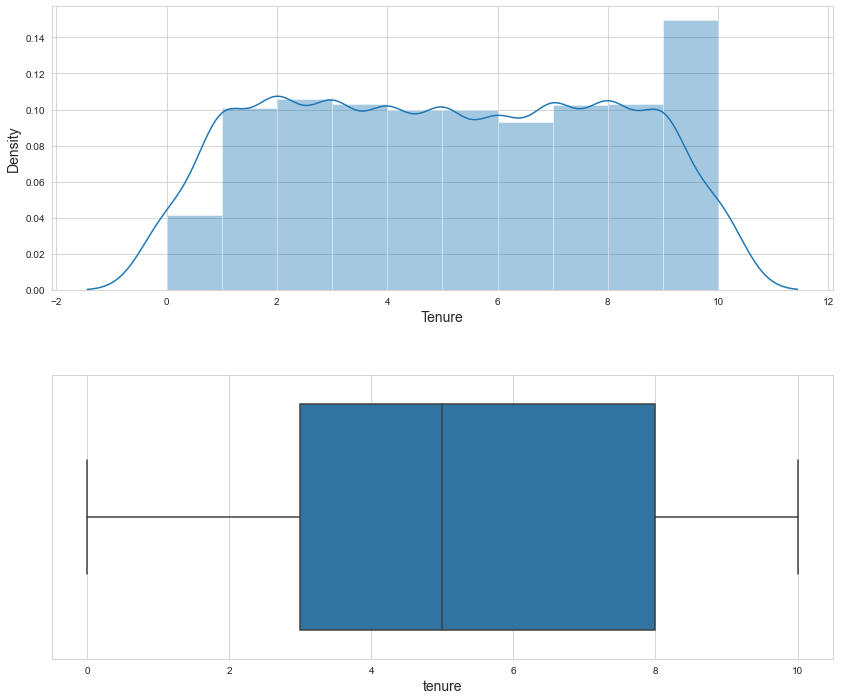

Tenure boundaries for outliers:
Q1 = 3.0
Q3 = 8.0
IQR = 5.0
low_outliers = -4.5
high_outliers = 15.5


In [31]:
figure, gr = plt.subplots()

gr.figure.set_size_inches(14,12)

plt.subplot(2,1,1)
gr = sns.distplot(df1['tenure'], bins=10)
plt.xlabel('Tenure', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
gr = sns.boxplot(df1['tenure'])
plt.xlabel('tenure', fontsize=14)
plt.show()

# Calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['tenure'], 0.25)
Q3 = np.quantile(df1['tenure'], 0.75)
IQR = Q3 - Q1

# Calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print('Tenure boundaries for outliers:')
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

**Observation:**

- We can observe that there are no outliers.

#### 1.6.1.4 Checking Balance

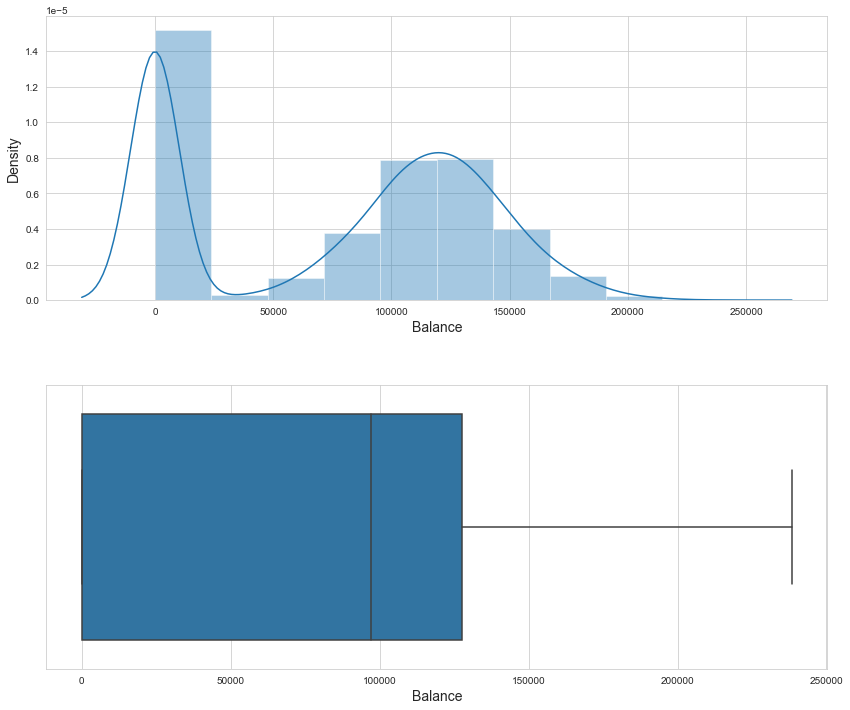

Balance boundaries for outliers:
Q1 = 0.0
Q3 = 127633.19499999999
IQR = 127633.19499999999
low_outliers = -191449.79249999998
high_outliers = 319082.9875


In [32]:
figure, gr = plt.subplots()

gr.figure.set_size_inches(14,12)

plt.subplot(2,1,1)
gr = sns.distplot(df1['balance'], bins=10)
plt.xlabel('Balance', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
gr = sns.boxplot(df1['balance'])
plt.xlabel('Balance', fontsize=14)
plt.show()

# Calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['balance'], 0.25)
Q3 = np.quantile(df1['balance'], 0.75)
IQR = Q3 - Q1

# Calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print('Balance boundaries for outliers:')
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

- We can observe that there are no outliers, but there are many null balance values in the first quartile.

#### 1.6.1.5 Checking Estimate Salary

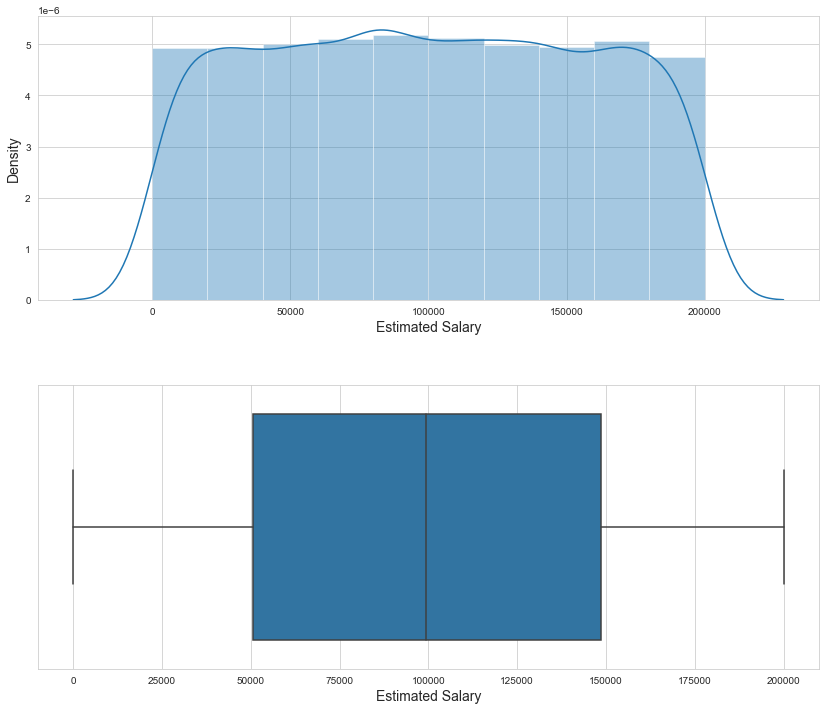

Age boundaries for outliers:
Q1 = 50691.817500000005
Q3 = 148527.72999999998
IQR = 97835.91249999998
low_outliers = -96062.05124999996
high_outliers = 295281.59874999995


In [33]:
figure, gr = plt.subplots()

gr.figure.set_size_inches(14,12)

plt.subplot(2,1,1)
gr = sns.distplot(df1['estimated_salary'], bins=10)
plt.xlabel('Estimated Salary', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
gr = sns.boxplot(df1['estimated_salary'])
plt.xlabel('Estimated Salary', fontsize=14)
plt.show()

# Calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['estimated_salary'], 0.25)
Q3 = np.quantile(df1['estimated_salary'], 0.75)
IQR = Q3 - Q1

# Calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print('Age boundaries for outliers:')
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

- We can observe that there are no outliers.

### 1.6.2 Categorical Variables

In [34]:
# checking categorical variables
cat_var.apply(lambda x: x.unique().shape[0])

surname             2620
geography              3
gender                 2
has_cr_card            2
is_active_member       2
exited                 2
dtype: int64

In [35]:
aux1 = df1[['geography', 'gender', 'balance']].groupby(['geography', 'gender']).sum().reset_index()

aux2 = df1[['geography', 'gender', 'estimated_salary']].groupby(['geography', 'gender']).sum().reset_index()

aux3 = df1[['geography', 'gender', 'num_of_products']].groupby(['geography', 'gender']).sum().reset_index()

<h4> Country </h4>

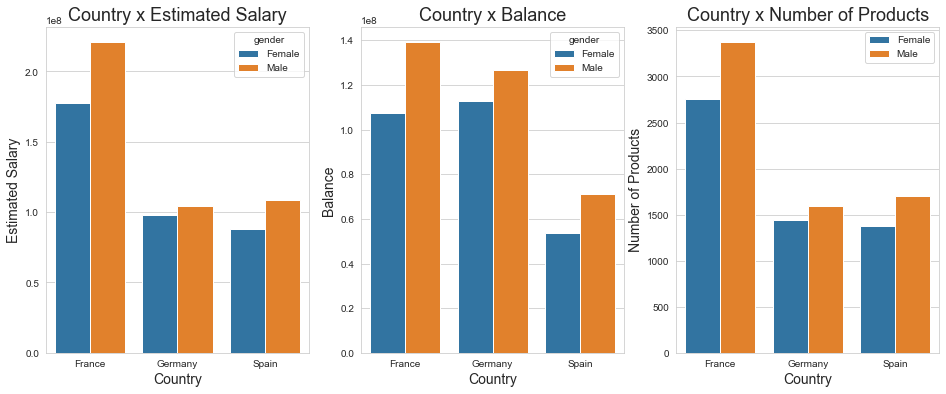

In [36]:
fig, gr = plt.subplots()

gr.figure.set_size_inches(16,6)

plt.subplot(1,3,1)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'estimated_salary', data=aux2)
set_plots_features(gr, 'Country x Estimated Salary', 'Country', 'Estimated Salary')

plt.subplot(1,3,2)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'balance', data=aux1)
set_plots_features(gr, 'Country x Balance', 'Country', 'Balance')

plt.subplot(1,3,3)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'num_of_products', data=aux3)
set_plots_features(gr, 'Country x Number of Products', 'Country', 'Number of Products')

# Legend
plt.legend()

# Display the plot
plt.show()

**Observations:**

- The estimated salary of the male gender is higher than the estimated salary of the female gender. And the French have the highest estimated salaries.
- The balance of the male gender is highter than the balance of the female gender.
- The male gender has more banking products than the female gender. And the French the largest purchases of banking products.

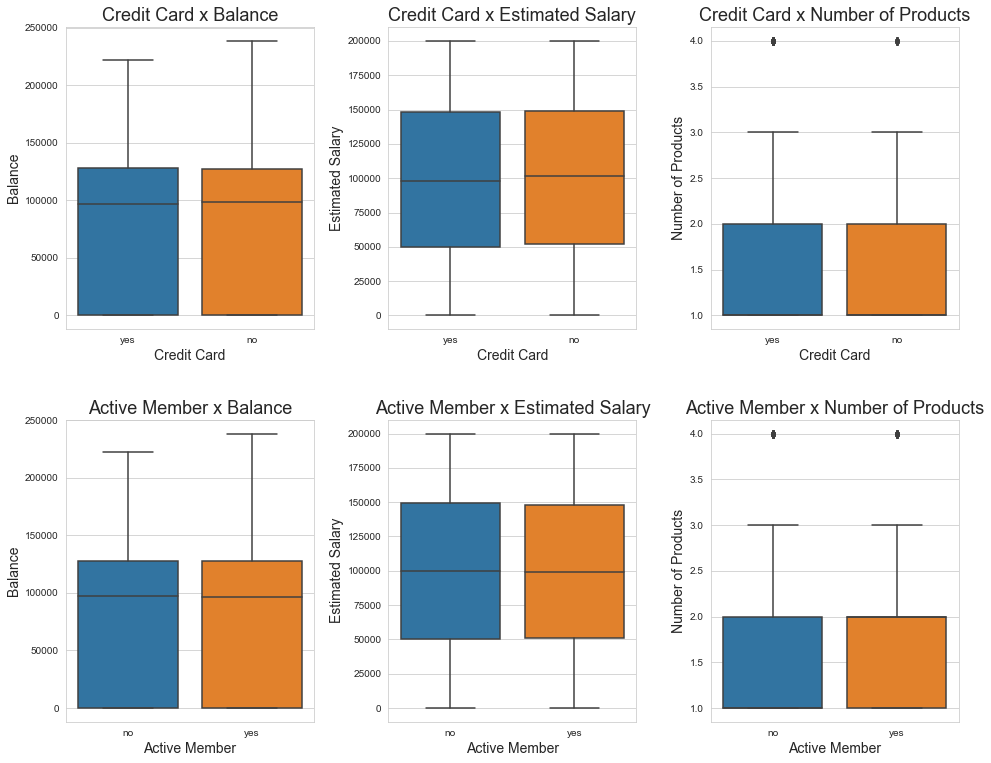

In [37]:
# Plotting boxplots of categorical variables
fig, gr = plt.subplots()

# size of figure
gr.figure.set_size_inches(16,20)

# Plots
plt.subplot(3, 3, 1)
gr = sns.boxplot(x = 'has_cr_card', y = 'balance', data=df1)
set_plots_features(gr, 'Credit Card x Balance', 'Credit Card', 'Balance')

plt.subplot(3, 3, 2)
gr = sns.boxplot(x = 'has_cr_card', y = 'estimated_salary', data=df1)
set_plots_features(gr, 'Credit Card x Estimated Salary', 'Credit Card', 'Estimated Salary')

plt.subplot(3, 3, 3)
gr = sns.boxplot(x = 'has_cr_card', y = 'num_of_products', data=df1)
set_plots_features(gr, 'Credit Card x Number of Products', 'Credit Card', 'Number of Products')

# Plots
plt.subplot(3, 3, 4)
gr = sns.boxplot(x = 'is_active_member', y = 'balance', data=df1)
set_plots_features(gr, 'Active Member x Balance', 'Active Member', 'Balance')

plt.subplot(3, 3, 5)
gr = sns.boxplot(x = 'is_active_member', y = 'estimated_salary', data=df1)
set_plots_features(gr, 'Active Member x Estimated Salary', 'Active Member', 'Estimated Salary')

plt.subplot(3, 3, 6)
gr = sns.boxplot(x = 'is_active_member', y = 'num_of_products', data=df1)
set_plots_features(gr, 'Active Member x Number of Products', 'Active Member', 'Number of Products')

plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()

**Observations:**

- Credit Card x Balance: There is no difference in the balance of credit card customers compared to non-credit card customers.
- Credit Card x Estimated Salary: There is no difference in the estimated salaries of customers with or without credit cards.
- Credit Card x Number of Products: There is no difference in the number of products with customers who have a credit card or not.
- Active Member x Balance: Customers with bank transactions and without bank transactions have practically the same median between their balances.
- Active Member x Estimated Salary: There is no difference in the estimated salaries of customers with banking transactions or not.
- Active Member x Number of Products: There is no difference in the number of products with customers who have banking transactions or not.


# 2.0 Feature Engineering 

At this stage, we will make the Mental Hypothesis Map, the Hypothesis Creation and Featuring Engineering to have the variables available for study during **Exploratory Data Analysis**. Before, with **module 1** already finished, we will make a copy of what has been done so far.

In [38]:
# Salving copy the data
df2 = df1.copy()

## 2.1 Mental Hypothesis Map

This step is extremely important because it will help to organize ideas in a simpler and more efficient way for hypotheses that we are willing to elaborate. Therefore, in the image below, we will put some characteristics, whose requirements we consider relevant, that help **in the exit of the customers of the bank**.

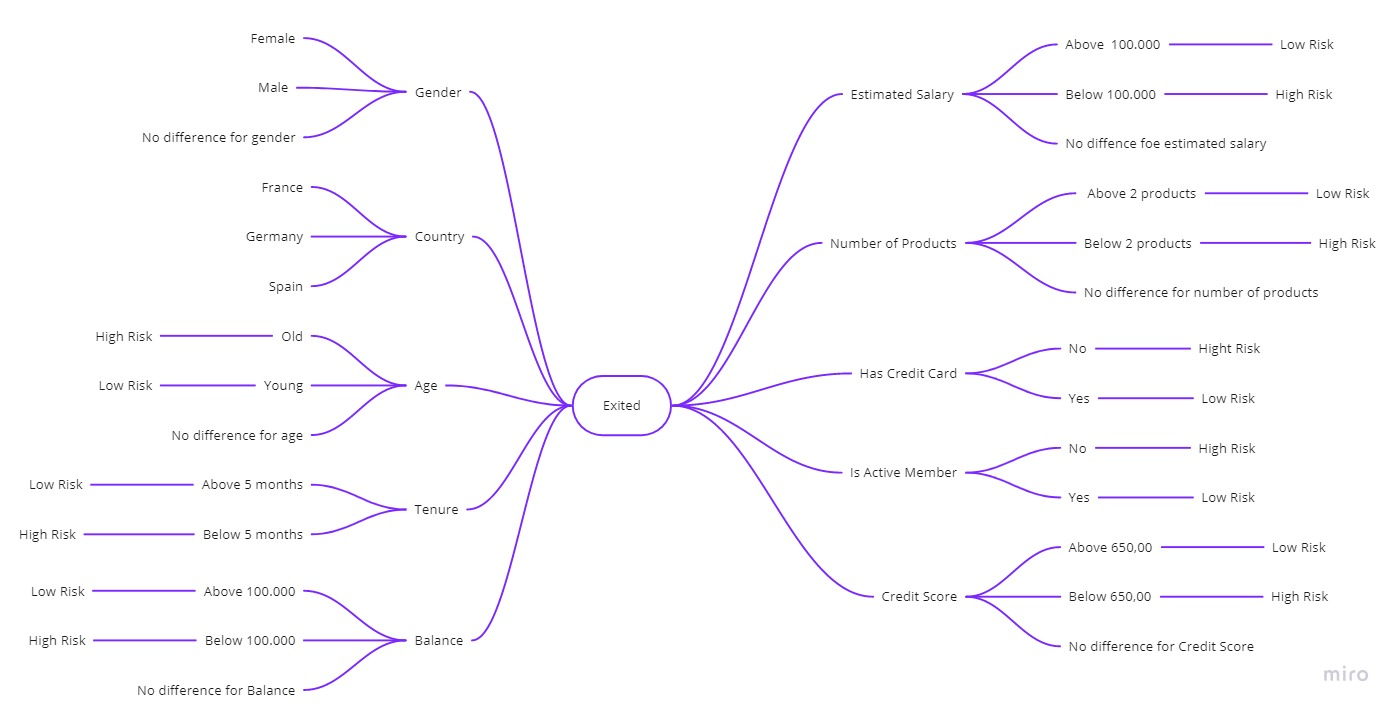

In [39]:
# Mental Hypothesis Map
Image('C:/Users/diasn/projeto_aluno/pa003_churn_predict/image/exited.jpg')

Looking at the image above, we put as central filter **Exited**, because we look for characteristics that help the evolution of this target variable. Therefore, we found it necessary to evaluate ten requirements that lead customers to leave the bank. In this case: **Gender, Country, Age, Tenure, Balance, Estimated Salary, Number of products, Has credit card, Is active member and Credit score**.

Elaborating the reasoning in this way, from this Mind Map, we will create the respective hypotheses.

## 2.2 Creating Hypothesis

**H1.** Male customers have more risk of exit than female customers.

**H2.** German customers have a high risk of exit more than  Spanish and French customers.

**H3.** Old customers run a higher risk of exit than young customers.

**H4.** Customers who remained active for more than 5 months have a low risk of exit than customers who remained active for less than 5 months.

**H5.** Customers with monetary values above 100.000 euros have a low risk of exit than customers with monetary values below 100.000 euros.

**H6.** Customers that have estimated salaries above 100.000 euros have a low risk of exit than customers that have estimated salaries below 100.000 euros.

**H7.** Customers that have more than 2 banking products have a low risk of exit than customers that have less than 2 banking products.

**H8.** Customers with a credit card have a low risk of exit than customers without a credit card.

**H9.** Customers with bank transactions have a low risk of exit than customers without bank transactions.

**H10.** Customers with credit above 650 euros have a low risk of exit than customers with credit below 650 euros.

**H11.** Customers with credit cards and bank transactions have a low risk of leaving the bank.

**H12.** Customers who have remained active and with a credit card have a low risk of leaving the bank.

**H13.** Customers who have remained active and with bank movements have low risk of leaving the bank.

**H14.** Customers with low salaries are more likely to leave the bank than customers with medium and high salaries.

## 2.3 Featuring Engineering 

With the creation of the hypotheses already made, in this section, we will make the process of **Feature Engineering**, that is, we will create new variables based on what has already been analyzed in *descriptive statistics* and the *creation of the respective hypotheses*.

### 2.3.1 Age Group

We will create a variable with age range based on the following criteria:

- young: people under the age of 20.
- adult: people aged between 20 and 60 years.
- old: people above the age of 60.

In [40]:
df2['age_group'] = df2['age'].apply(lambda x: 'young' if x < 20 else 'adult' if 20 <= x < 60 else 'old' )

### 2.3.2 Estimated Salary Range

We will create the variable `estimated_salary_range` to know the salary range of each client.

- Low: Estimated salary below 13.000 euros
- Medium: Estimated salary between 13.000 and 30.000 euros.
- High: Estimated salary above of 30.000 euros.

**Note:** https://www.dw.com/pt-br/infogr%C3%A1fico-quanto-voc%C3%AA-tem-de-ganhar-para-ser-rico-na-europa/a-40562948

In [41]:
df2['estimated_salary_range'] = df2['estimated_salary'].apply(lambda x: 'low' if x < 13000 else 'medium' if x <= 30000 
                                                              else 'high')

### 2.3.3 Balance/ Tenure

We will create a variable referring to the balance that the clients have in relation to the time that they remained active or not. That is:

- yes: if balance > 0 and tenure > 0.
- no: if balance < 0 and tenure < 0.
- only balance: if balance > 0 and tenure < 0.
- only tenure: if balance < and tenure > 0.

In [42]:
df2['balance_tenure'] = df2.apply(lambda x: 'yes' if (x['balance'] > 0) and (x['tenure'] > 0) 
                                  else 'no' if (x['balance'] < 0) and (x['tenure'] < 0)
                                  else 'only balance' if (x['balance'] > 0) and (x['tenure'] < 0)
                                  else 'only tenure', axis=1)

### 2.3.4 Balance/Is Active Member

We will create a variable referring to the balance that customers have in relation to their banking transactions.

- yes: if balance > 0 and is active member.
- no: if balance < 0 and is not active member.
- only balance: if balance > 0 and is not active member.
- only active member: if balance < 0 and is active member.

In [43]:
df2['balance_active'] = df2.apply(lambda x: 'yes' if (x['balance'] != 0) and (x['is_active_member']=='yes')
                                  else 'no' if (x['balance']==0) and (x['is_active_member']=='no')
                                  else 'only balance' if (x['balance'] != 0) and (x['is_active_member']=='no')
                                  else 'only active member', axis=1)
                    

### 2.3.5 Has Credit Card/Is Active Member

We will create a variable based on customers who either have a credit card or not and who have or have not made bank transactions. That is:

- yes: if has credit card and is active member
- no: if has not credit card nad is not active member.
- only credit card: if has credit card and is not active member.
- only active member: if not has credit card and is active member.

In [44]:
df2['has_cr_card_active_member'] = df2.apply(lambda x: 'yes' if (x['has_cr_card']=='yes') and (x['is_active_member']=='yes') 
                                   else 'no' if (x['has_cr_card']=='no') and (x['is_active_member']=='no') 
                                   else 'only credit card' if (x['has_cr_card']=='yes') and (x['is_active_member']=='no')
                                   else 'only active member', axis=1)
                                            

### 2.3.6 Tenure/Has Credit Card

We will create a variable based on how long customers have been active and whether or not they have a credit card in the bank. That is:

- yes: if tenure > 0 and has credit card.
- no: if tenure < 0 and has not credit card.
- only tenure: if tenure > 0 and has not credit card.
- only credit card: if tenure < 0 and has credit card.

In [45]:
df2['tenure_has_cr_card'] = df2.apply(lambda x: 'yes' if (x['tenure'] > 0) and (x['has_cr_card']=='yes') 
                                      else 'no' if (x['tenure'] < 0) and (x['has_cr_card']=='no') 
                                      else 'only tenure' if (x['tenure'] > 0) and (x['has_cr_card']=='no') 
                                      else 'only credit card', axis=1)

### 2.3.7 Tenure/Is Active Member

We will create a variable based on how long customers have been active and whether or not they have made bank transactions. That is:

- yes: if tenure > 0 and is active member.
- no: if tenura < 0 and is not active member.
- only tenure: if tenure > 0 and is not active member.
- only active member: if tenure < 0 and only active member.

In [46]:
df2['tenure_is_active_member'] =df2.apply(lambda x: 'yes' if (x['tenure'] > 0) and (x['is_active_member']=='yes') 
                                          else 'no' if (x['tenure'] < 0) and (x['is_active_member']=='no') 
                                          else 'only tenure' if (x['tenure'] > 0) and (x['is_active_member']=='no') 
                                          else 'only active member', axis=1)

# 3.0 Filtering Variables

In this module, we will do the variable filter, that is, we will analyze the data set to identify it is possible to restrict some data that is not relevant for exploratory data analysis by doing the following steps:

- Filtering Rows

- Selecting Columns

Howerer, as a procedure already established, we will save a copy of the data set before starting the activities.

In [47]:
# Salving a copy of the data set
df3 = df2.copy()

## 3.1 FIltering Rows


We will restrict some data based on the estimated salary and age, because as was seen in module 1, we estimate the salaries with strange values. And also because we have outliers values.

Researching, we have that the minimum wage in the three European countries is:

- Minimal Salary in the France: 1.522,21 euros

- Minimal Salary in the Germany: 1.557,00 euros

- Minimal Salary in the Spain: 1.050,00 euros

**Reference:** https://ec.europa.eu/eurostat/en/web/products-datasets/-/EARN_MW_CUR

As the estimated salary is annual, we will consider salaries above 6000 euros. And also, analyzing the customers' ages, we will consider customers up to 75 years old.

In [48]:
# Estimated salary
df3 = df3[(df3['estimated_salary'] > 6000) & (df3['age'] < 75 )]

## 3.2 Selected Columns

In the selection of columns, we will exclude until this moment, only the surname variable.

In [49]:
df3 = df3.drop(['surname', 'customer_id'], axis=1)

## 3.3 New Data Set

In [50]:
print(f'Number of Rows: {df3.shape[0]}')
print(f'Number of Columns : {df3.shape[1]}')

Number of Rows: 7714
Number of Columns : 19


# 4.0 Exploratory Data Analysis

In summary, the importance of Exploratory Data Analysis is to understand and measure the strengths of how variables impact on the phenomenon we are modeling. Therefore, the objectives of the EDA are:

- Gain business experience

- Validate business hypotheses.

- Understand which variables are important to the business.

Therefore, we will do three types of analysis: **univariate analysis, bivariate analysis and multivariate analysis**.

In [51]:
# Salving copy of the data
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target Variable

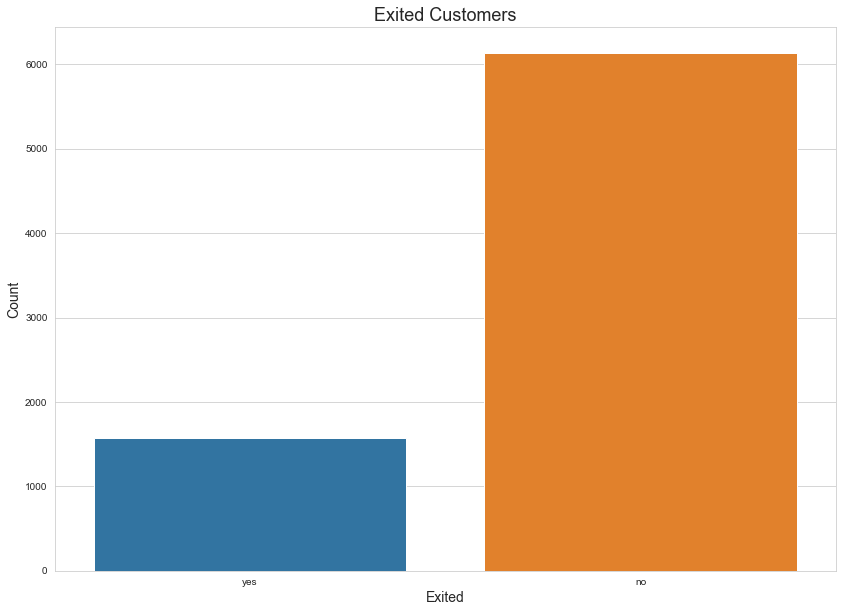

In [52]:
figure, gr = plt.subplots()

# Figure size
gr.figure.set_size_inches(14,10)

# Target Variable
gr = sns.countplot(df4['exited'])
set_plots_features(gr, 'Exited Customers', 'Exited', 'Count')

# Display the plot
plt.show()

In [53]:
df4['exited'].value_counts(normalize=True)

no     0.795307
yes    0.204693
Name: exited, dtype: float64

**Observations:**

Exited Customers:

- yes: 20.47%
- no : 79.53%



### 4.1.2 Numerical Variables

In [54]:
num_var1 = df4.select_dtypes(exclude=['object'])
num_var1.columns
num_var1 = num_var1.drop(['row_number'], axis=1)

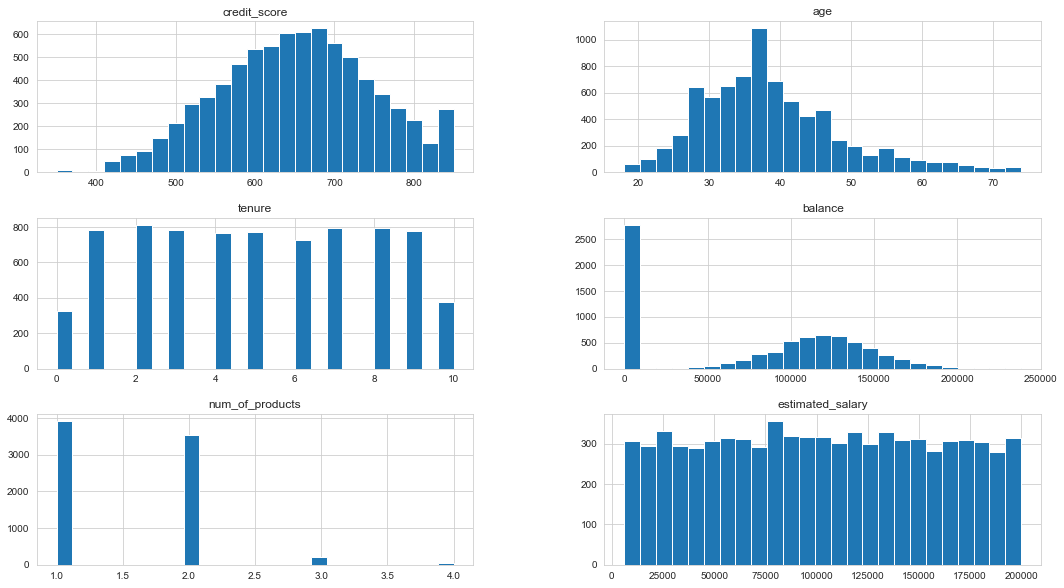

In [55]:
# Plotting the numerical variables distributions
fig = plt.figure(figsize=(18,10))

gr = fig.gca()
    
num_var1.hist(ax = gr, bins = 25)

plt.show()

**Observations:**

- The credit score is close to a normal distribution.
- Most customers are between 30 and 40 years of age.
- There is a balance between the number of months customers have been active at the bank.
- More than 2500 customers (+ 32.41%) have a zero account value.
- More than 95% of customers have between 1 and 2 products.
- There is a balance between the number of customers and their estimated salaries.

### 4.1.3 Categorical Variables

In [56]:
cat_var1 = df4.select_dtypes(include=['object'])
cat_var1.columns

Index(['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited',
       'age_group', 'estimated_salary_range', 'balance_tenure',
       'balance_active', 'has_cr_card_active_member', 'tenure_has_cr_card',
       'tenure_is_active_member'],
      dtype='object')

In [57]:
cat_var2 = df4[['geography', 'gender', 'has_cr_card', 'is_active_member',
       'age_group', 'estimated_salary_range', 'balance_tenure',
       'balance_active', 'has_cr_card_active_member', 'tenure_has_cr_card',
       'tenure_is_active_member']]

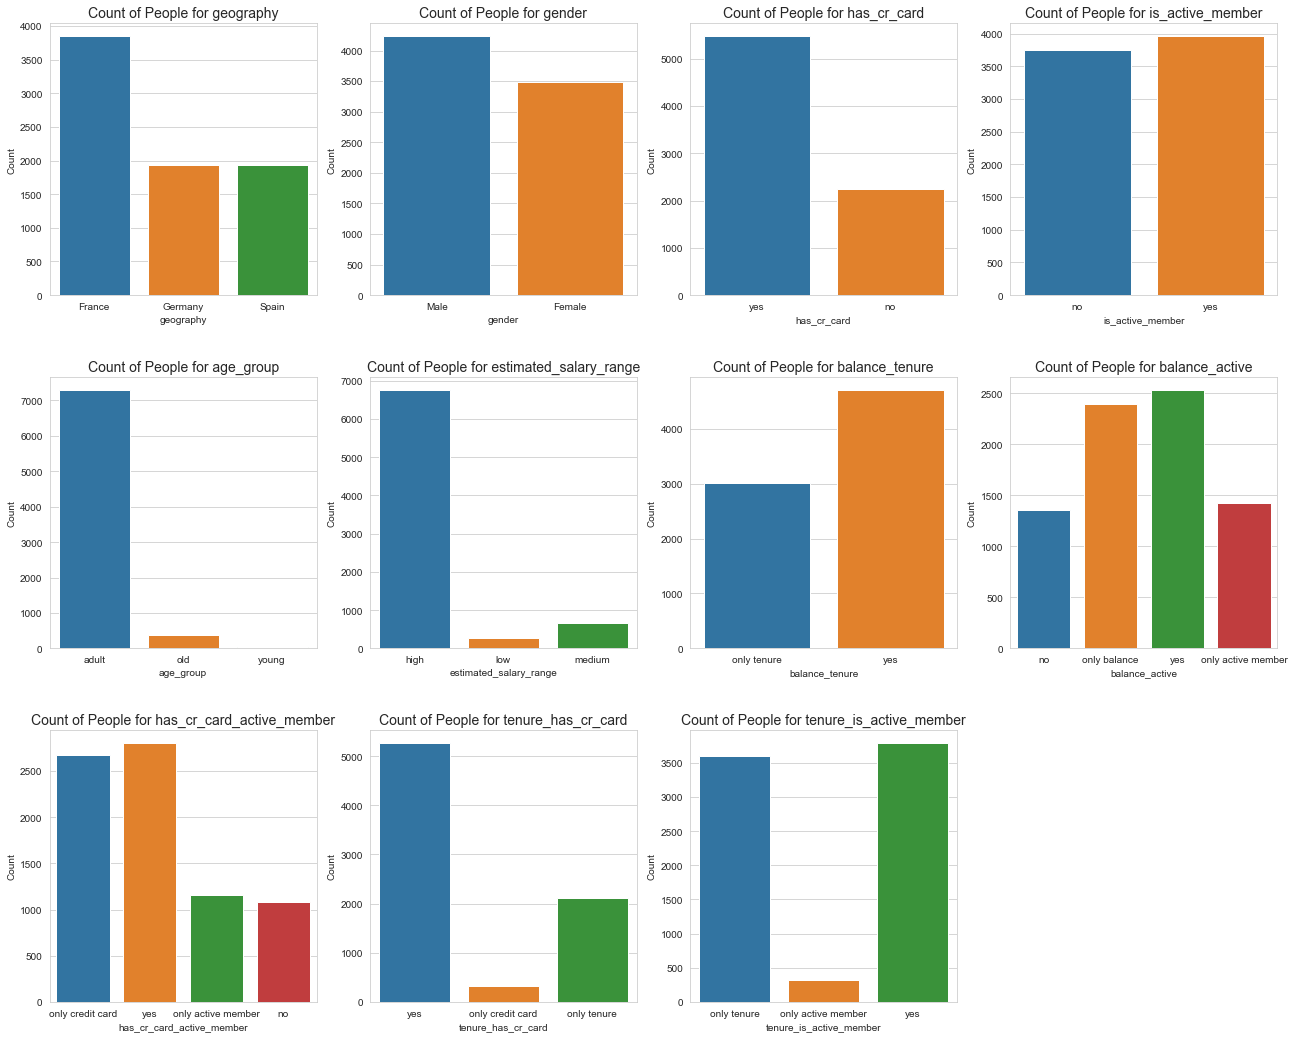

In [58]:
# sets plot size
plt.figure(figsize=(22,18))

# sets the initial plot position
n = 1

# Iterates over the columns to plot
for column in cat_var2.columns:
    plt.subplot(3,4,n)
    _ = sns.countplot(x=cat_var2[column])
    plt.title("Count of People for " + column, fontsize=14)
    plt.xlabel(column, fontsize=10)
    plt.ylabel("Count", fontsize=10)
    n += 1
    
# Adjust height reserved for space between subplots  
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()

**Observations:**

- There are more French customers (49.90%) than German (25.02%) and Spanish (25.08%) customers in the bank.
- There are more male customers (54.87%) than female customers (45.13%) in the bank.
- There are more customers with credit cards (70.99%) than customers without credit cards (29.01%) in the bank.
- There is a balance between customers having bank transactions with customers (51.36%) who do not have bank transactions (48.64%).
- There are more adult customers (94.70%) than young and old customers (0.04% and 4.86%) in the bank.
- About 87.70% of clients have high estimated salaries, 8.71% have medium estimated salaries and 3.59% have low estimated salaries.
- 4709 customers have balance and remained active in the bank. And 3005 customers only remained active, but without balance.
- 2535 customers have a balance and have made bank movements. 2394 customers only have a balance and have not made bank transactions. 1427 customers only made bank movements. And 1358 customers made nothing.
- There are more customers who have a credit card and have made bank transactions (36.36%) and also more customers who only have a credit card (34.63%).
- There are more customers that have remained active and have credit cards (68.32%).
- There is a balance between the number of customers who remained active with banking transactions than customers who only remained active (49.16% and 46.64%).

## 4.2 Bivariate Analysis

### H1. Male customers have more risk of leaving the bank than female customers.
**FALSE:** Female customers have high risk of leaving the bank.

In [59]:
gender_exited_female = df4[df4['gender']=='Female']
gender_exited_male = df4[df4['gender']=='Male']

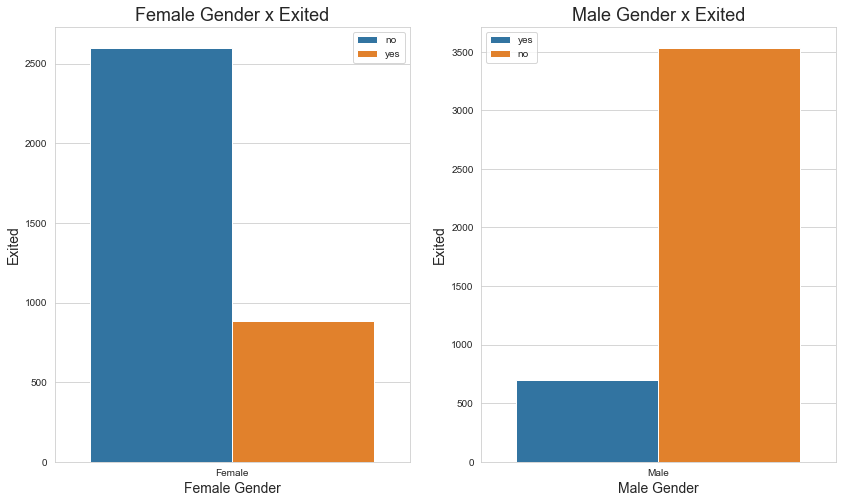

In [60]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
plt.subplot(1,2,1)
gr = sns.countplot(x = 'gender', hue='exited', data=gender_exited_female)
set_plots_features(gr, 'Female Gender x Exited', 'Female Gender', 'Exited')
plt.legend()

plt.subplot(1,2,2)
gr = sns.countplot(x = 'gender', hue='exited', data=gender_exited_male)
set_plots_features(gr, 'Male Gender x Exited', 'Male Gender', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Female customers have a higher risk of exit than male customers.

### H2. German customers have a high risk of leaving the bank more than  Spanish and French customers.
**FALSE:** French and German customers have the highest risks of leaving the bank.

In [61]:
country_exited = df4[['geography', 'exited']]

In [62]:
aux1 = country_exited[country_exited['exited']=='yes']

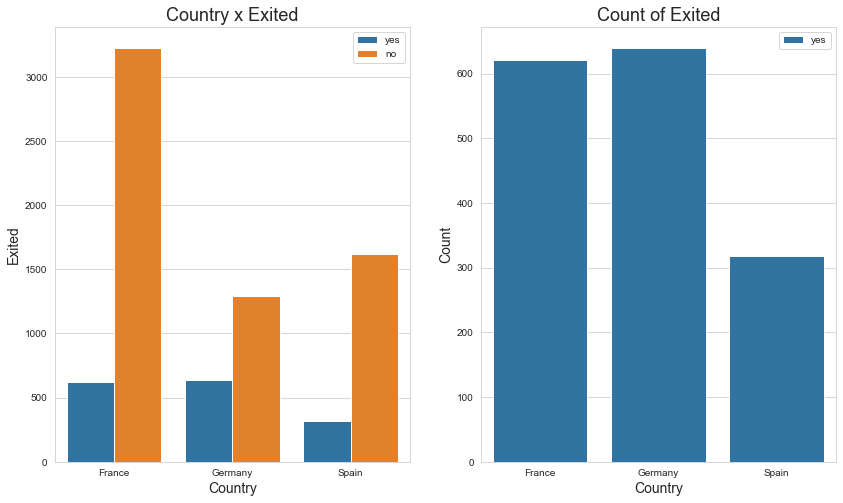

In [63]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
plt.subplot(1,2,1)
gr = sns.countplot(x = 'geography', hue='exited', data=country_exited)
set_plots_features(gr, 'Country x Exited', 'Country', 'Exited')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(x = 'geography', hue='exited', data=aux1)
set_plots_features(gr, 'Count of Exited', 'Country', 'Count')
plt.legend()
# Display the plot
plt.show()

**Observation:**

- French and German customers have the highest risks of leaving the bank.

### H3. Old customers have a higher risk of leaving the bank than young customers.
**FALSE:** Adult customers have higher risk of leaving the bank.

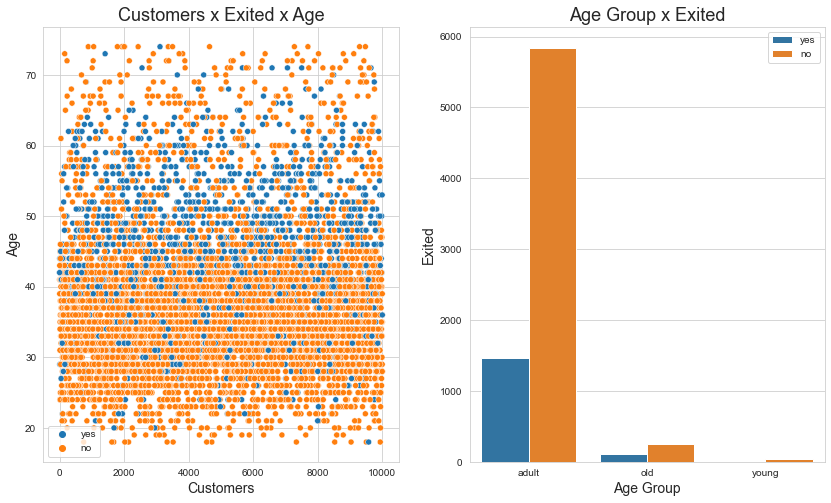

In [64]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue='exited', y= 'age', data=df4)
set_plots_features(gr, 'Customers x Exited x Age', 'Customers', 'Age')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(x = 'age_group', hue= 'exited', data=df4)
set_plots_features(gr, 'Age Group x Exited', 'Age Group', 'Exited')
plt.legend()

# Display the plot
plt.show()

**Observation:**

- Adult customers have a high risk of leaving the bank than old or young customers.

### H4. Customers that remained active for more than 5 months have a low risk of leaving the bank than customers that remained active for less than 5 months.
**FALSE:** There is no difference in the number of customers leaving in relation to the number of months that customers remained active.

In [65]:
tenure_exited = df4[['tenure', 'exited']]
aux = tenure_exited[tenure_exited['exited']=='yes']

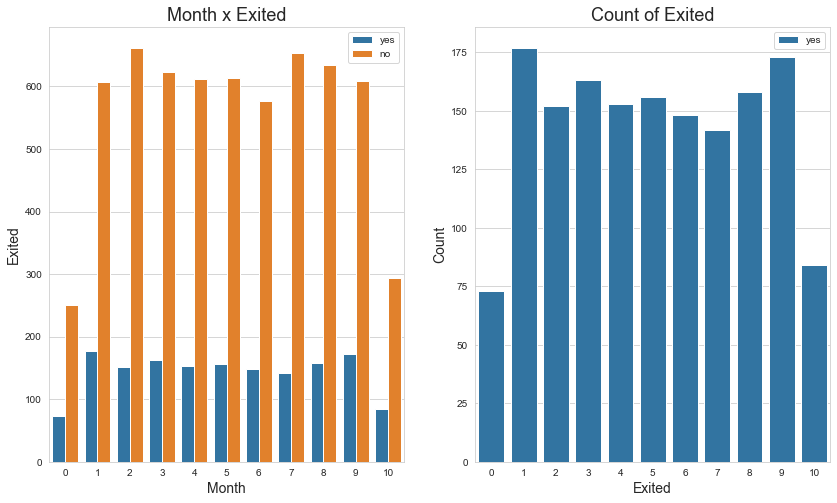

In [66]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
plt.subplot(1,2,1)
gr = sns.countplot(x = 'tenure', hue= 'exited', data=tenure_exited)
set_plots_features(gr, 'Month x Exited', 'Month', 'Exited')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(x = 'tenure', hue= 'exited', data=aux)
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count')
plt.legend()

# Display the plot
plt.show()

**Observation:**

- There is no difference in the number of customers leaving in relation to the number of months that customers remained active.

### H5. Customers with monetary values above 100.000 euros have a low risk of leaving the bank than customers with monetary values below 100.000 euros.
**FALSE**: Customers with monetary values above 100.000 euros have a high risk of leaving the bank.

<h4> Monetary Values below 100.000 euros </h4>

In [67]:
balance01= df4[df4['balance'] <= 100000]
balance01['exited'].value_counts(normalize=True)

no     0.839312
yes    0.160688
Name: exited, dtype: float64

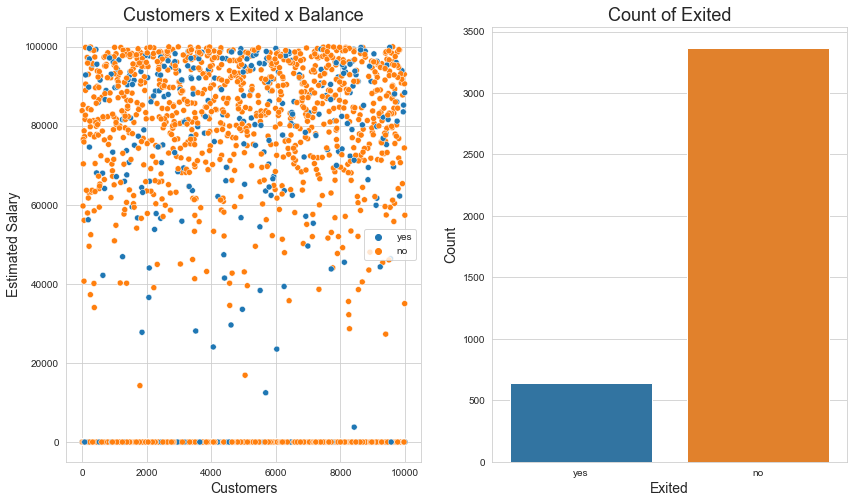

In [68]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue= 'exited', y='balance', data=balance01)
set_plots_features(gr, 'Customers x Exited x Balance', 'Customers', 'Estimated Salary')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(balance01['exited'])
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count')

# Display the plot
plt.show()

**Observation:**

- About 16% of clients with below average monetary values exited the bank.

<h4> Monetary Values above 100.000 euros </h4>

In [69]:
balance02 = df4[df4['balance'] > 100000]
balance02['exited'].value_counts(normalize=True)

no     0.747568
yes    0.252432
Name: exited, dtype: float64

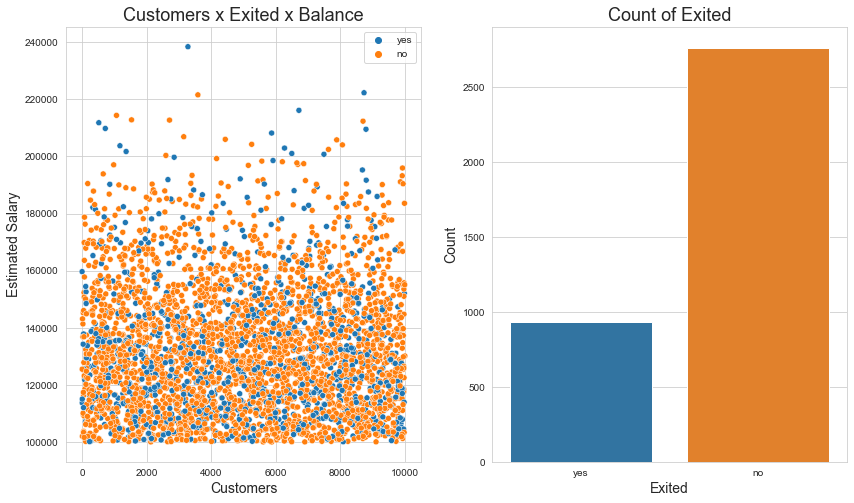

In [70]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue= 'exited', y='balance', data=balance02)
set_plots_features(gr, 'Customers x Exited x Balance', 'Customers', 'Estimated Salary')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(balance02['exited'])
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count')

# Display the plot
plt.show()

**Observation:**

- About 25% of customers with above average monetary values left the bank.

### H6. Clients who have estimated salaries above 100.000 euros have a lower risk of leaving the bank than clients who have estimated salaries below 100.000 euros.

**FALSE:** The estimated salaries of the customers do not differ in their exits from the bank.

<h4> Estimated Salary below 100.000 euros </h4>

In [71]:
estimated_salary01 = df4[df4['estimated_salary'] <= 100000]
estimated_salary01.shape

(3758, 19)

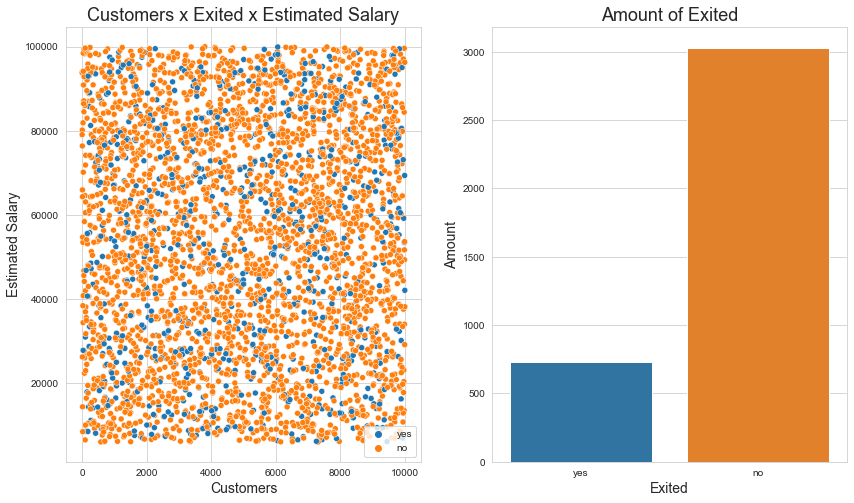

In [72]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue= 'exited', y='estimated_salary', data=estimated_salary01)
set_plots_features(gr, 'Customers x Exited x Estimated Salary', 'Customers', 'Estimated Salary')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(estimated_salary01['exited'])
set_plots_features(gr, 'Amount of Exited', 'Exited', 'Amount')

# Display the plot
plt.show()

In [73]:
print('Percentage')
round(estimated_salary01['exited'].value_counts(normalize=True),4)*100

Percentage


no     80.63
yes    19.37
Name: exited, dtype: float64

**Observation:**

- About 19.37% of the clients with an estimated salary below 100,000 euros have the risk of leaving the bank.

<h4> Estimated Salary above 100.000 euros </h4>

In [74]:
estimated_salary02 = df4[df4['estimated_salary'] > 100000]
estimated_salary02.shape

(3956, 19)

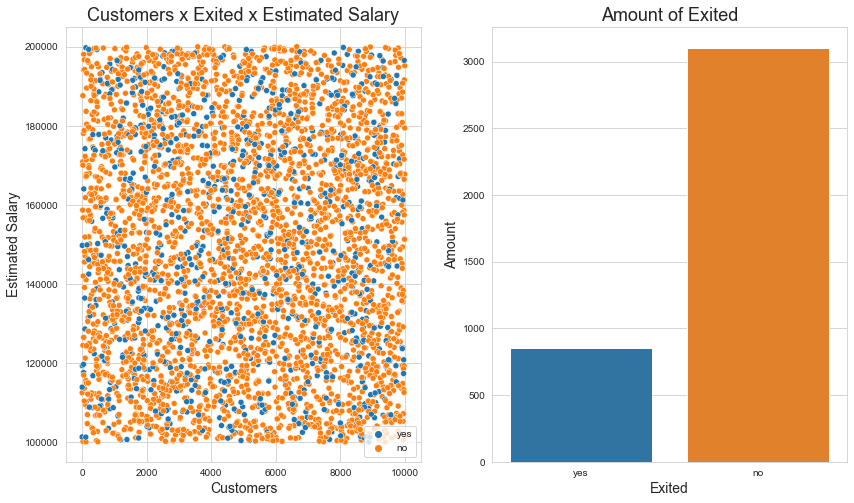

In [75]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue= 'exited', y='estimated_salary', data=estimated_salary02)
set_plots_features(gr, 'Customers x Exited x Estimated Salary', 'Customers', 'Estimated Salary')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(estimated_salary02['exited'])
set_plots_features(gr, 'Amount of Exited', 'Exited', 'Amount')

# Display the plot
plt.show()

In [76]:
print('Percentage')
round(estimated_salary02['exited'].value_counts(normalize=True),4)*100

Percentage


no     78.49
yes    21.51
Name: exited, dtype: float64

**Observation:**

- About 21.51% of the clients with an estimated salary above 100,000 euros have the risk of leaving the bank. 

### H7. Customers who have more than 2 banking products have a low risk of leaving the bank than customers that who less than 2 banking products.
**TRUE:** Customers who have more than 2 banking products have a low risk of leaving the bank.

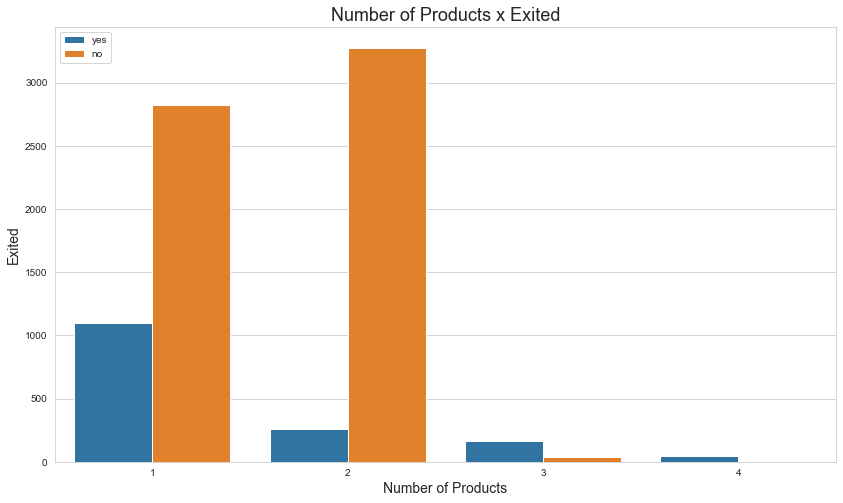

In [77]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'num_of_products', hue='exited', data=df4)
set_plots_features(gr, 'Number of Products x Exited', 'Number of Products', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Customers who have more than 2 banking products have a low exit risk than customers who have less than 2 banking products.

### H8. Customers with a credit card have a low risk of exit than customers without a credit card.
**FALSE:** Customers with a credit card have a high risk of left the bank than customers without a credit card.

In [78]:
credit = df4[df4['has_cr_card']=='yes']

In [79]:
no_credit = df4[df4['has_cr_card']=='no']

In [80]:
credit['exited'].value_counts(normalize=False)

no     4372
yes    1104
Name: exited, dtype: int64

In [81]:
no_credit['exited'].value_counts(normalize=False)

no     1763
yes     475
Name: exited, dtype: int64

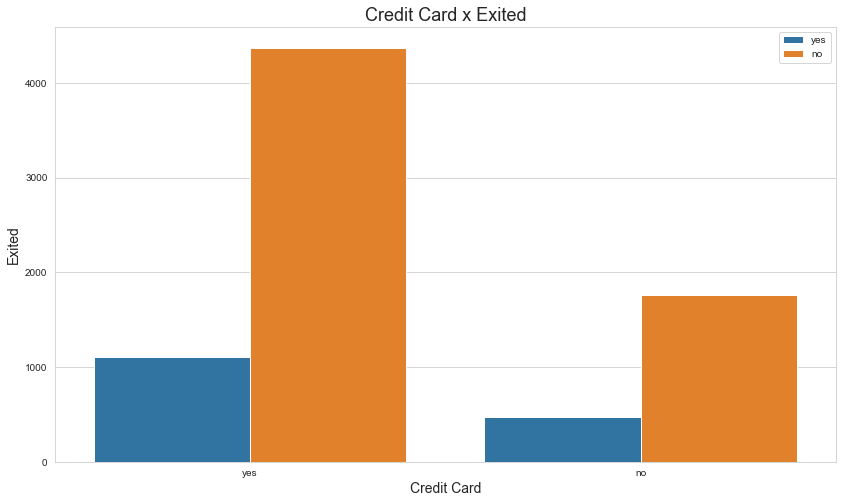

In [82]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'has_cr_card', hue='exited', data=df4)
set_plots_features(gr, 'Credit Card x Exited', 'Credit Card', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Customers with a credit card have a high risk of left the bank than customers without a credit card.
- About 70% of the customers who have a credit card will leave the bank.
- About 30% of the customers who do not have a credit card will leave the bank.

### H9. Customers with bank transactions have a low risk of exit than customers without bank transactions.
**FALSE:** Customers with bank transactions have a low risk of leaving than customers without bank transactions.

In [83]:
bank = df4[df4['is_active_member']=='yes']
no_bank = df4[df4['is_active_member']=='no']

In [84]:
bank['exited'].value_counts()

no     3385
yes     577
Name: exited, dtype: int64

In [85]:
no_bank['exited'].value_counts()

no     2750
yes    1002
Name: exited, dtype: int64

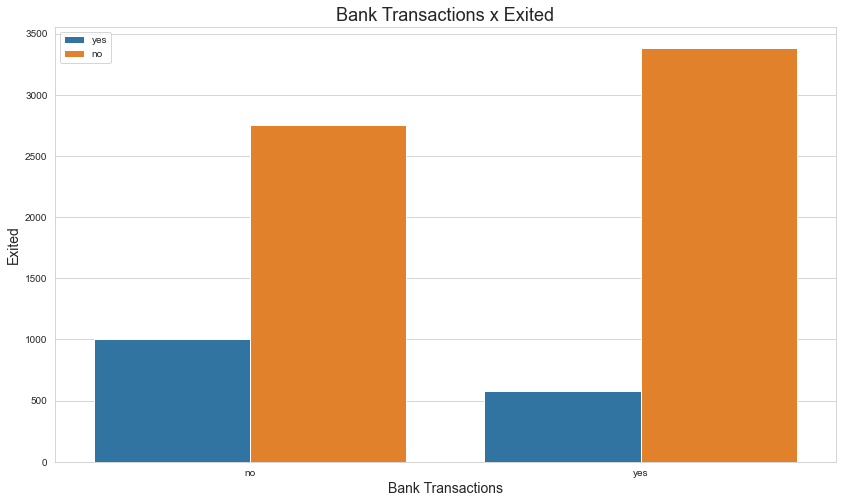

In [86]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'is_active_member', hue='exited', data=df4)
set_plots_features(gr, 'Bank Transactions x Exited', 'Bank Transactions', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Customers with bank transactions have a low risk of leaving than customers without bank transactions.
- About 36.54% of customers who have made bank transactions will leave the bank. 
- About 63.46% of the customers who did not make bank transactions will leave the bank. 

### H10. Customers with credit above 650 euros have a low risk of leaving the bank than customers with credit below 650 euros.

**TRUE:** Customers with credit above 650 euros have a low risk of leaving the bank.

<h4> Credit Score below 650 euros </h4>

In [87]:
credit_score01 = df4[df4['credit_score'] <= 650]
round(credit_score01['exited'].value_counts(normalize=True),4)*100

no     78.32
yes    21.68
Name: exited, dtype: float64

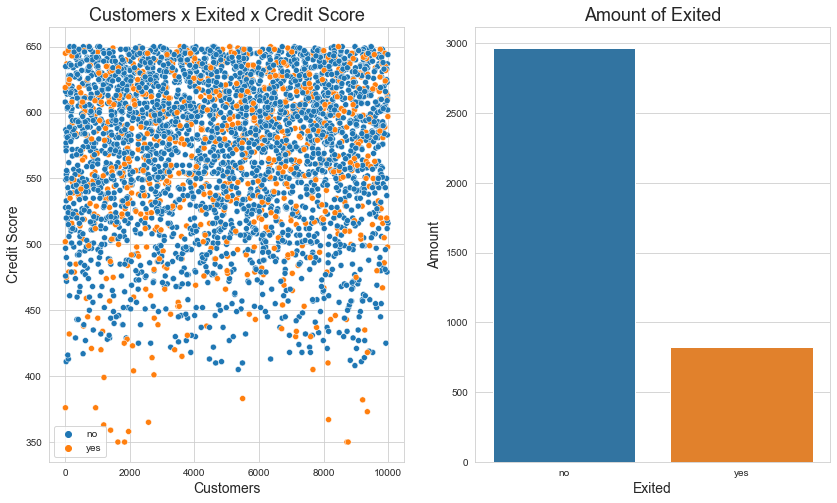

In [88]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue= 'exited', y='credit_score', data=credit_score01)
set_plots_features(gr, 'Customers x Exited x Credit Score', 'Customers', 'Credit Score')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(credit_score01['exited'])
set_plots_features(gr, 'Amount of Exited', 'Exited', 'Amount')

# Display the plot
plt.show()

**Observation:**

- About 21.68% of customers with below average credit left the bank.

<h4> Credit Score above 650 euros </h4>

In [89]:
credit_score02 = df4[df4['credit_score'] > 650]
round(credit_score02['exited'].value_counts(normalize=True),4)*100

no     80.7
yes    19.3
Name: exited, dtype: float64

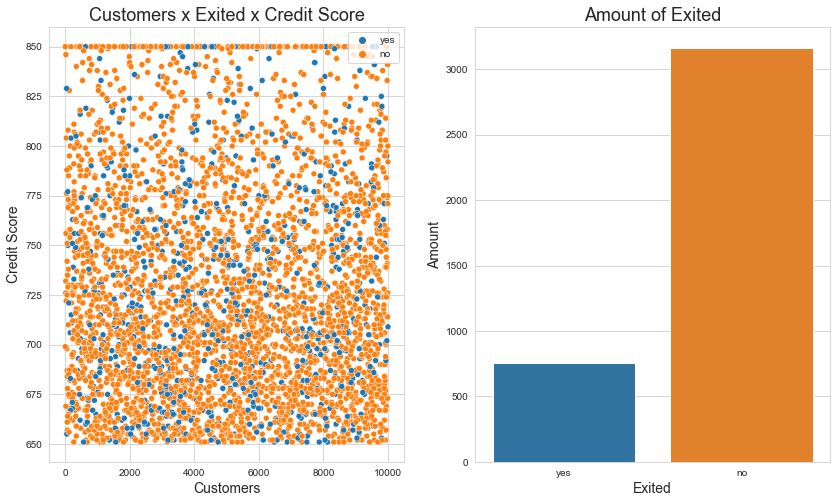

In [90]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
gr = sns.scatterplot(x = 'row_number', hue= 'exited', y='credit_score', data=credit_score02)
set_plots_features(gr, 'Customers x Exited x Credit Score', 'Customers', 'Credit Score')
plt.legend()

# Count Plot
plt.subplot(1,2,2)
gr = sns.countplot(credit_score02['exited'])
set_plots_features(gr, 'Amount of Exited', 'Exited', 'Amount')

# Display the plot
plt.show()

**Observation:**

- About 19.30% of customers with above average credit left the bank.

### H11. Customers with credit cards and bank transactions have a low risk of leaving the bank.
**FALSE:** Customers with only bank transactions have a low risk of leaving the bank.

In [91]:
aux = df4[['has_cr_card_active_member', 'exited']]

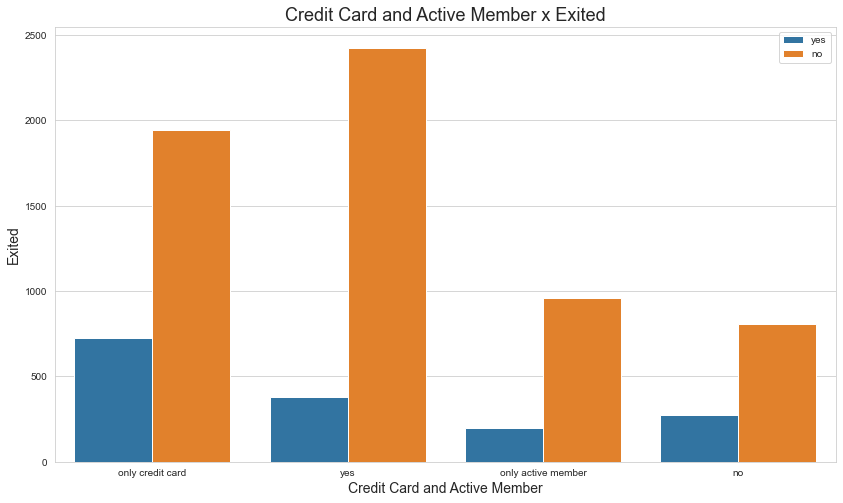

In [92]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'has_cr_card_active_member', hue='exited', data=aux)
set_plots_features(gr, 'Credit Card and Active Member x Exited', 'Credit Card and Active Member', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Customers with only bank transactions have a low risk of leaving the bank than other customers.

### H12. Customers who have remained active and with a credit card have a low risk of leaving the bank.
**FALSE:** Customers with only a credit card have a low risk of leaving the bank.

In [93]:
aux1 = df4[['tenure_has_cr_card', 'exited']]

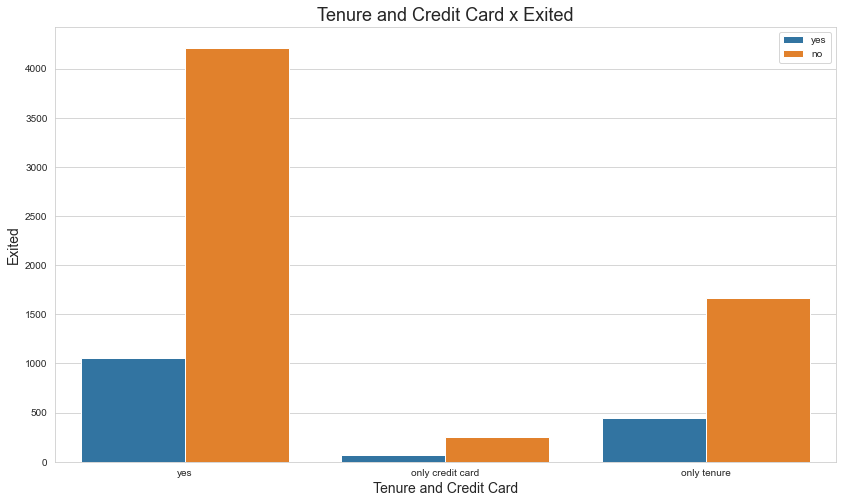

In [94]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'tenure_has_cr_card', hue='exited', data=aux1)
set_plots_features(gr, 'Tenure and Credit Card x Exited', 'Tenure and Credit Card', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Customers with only a credit card have a low risk of leaving the bank than other customers.

### H13. Customers who have remained active and with bank movements have low risk of leaving the bank.
**FALSE:** Customers who have only bank movements have low risk of leaving the bank.

In [95]:
aux2 = df4[['tenure_is_active_member', 'exited']]

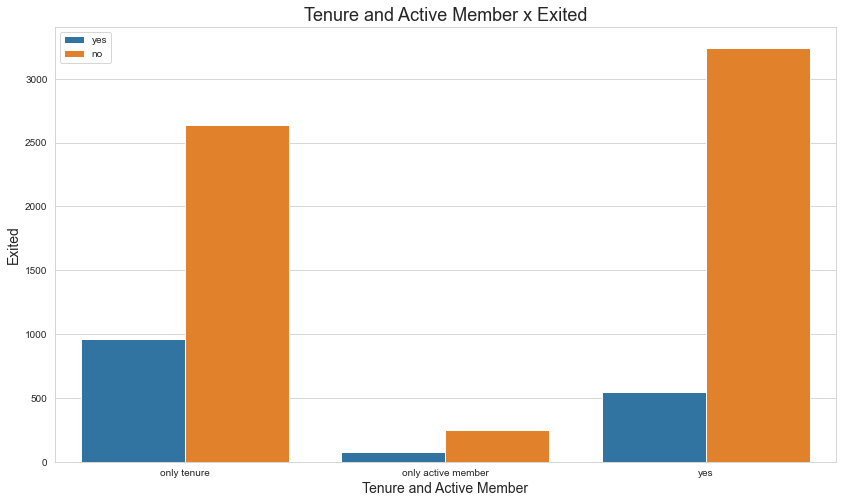

In [96]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'tenure_is_active_member', hue='exited', data=aux2)
set_plots_features(gr, 'Tenure and Active Member x Exited', 'Tenure and Active Member', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

**Observation:**

- Customers who have only remained active have a high risk of leaving the bank than other customers.

### H14. Customers with low salaries are more likely to leave the bank than customers with medium and high salaries.
**FALSE:** Customers with high salaries are more likely to leave the bank than customers with low and medium salaries.

In [97]:
aux = df4[['estimated_salary_range', 'exited']]

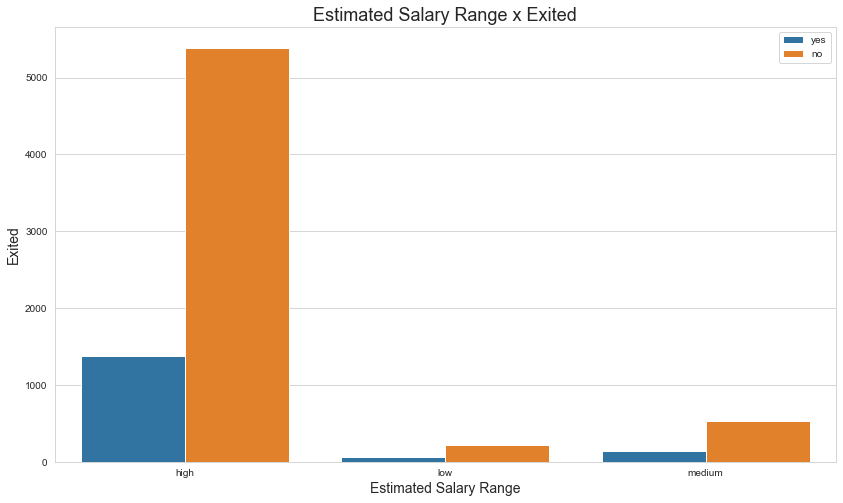

estimated_salary_range  exited
high                    no        5389
                        yes       1376
medium                  no         525
low                     no         221
medium                  yes        147
low                     yes         56
dtype: int64

In [98]:
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Count Plot
gr = sns.countplot(x = 'estimated_salary_range', hue='exited', data=aux)
set_plots_features(gr, 'Estimated Salary Range x Exited', 'Estimated Salary Range', 'Exited')
plt.legend()

# Exibição do gráfico
plt.show()

aux.value_counts(normalize=False)

In [99]:
aux1 = aux[aux['exited']=='yes']

In [100]:
high = len(aux1[aux1['estimated_salary_range']=='high'])/len(aux1)
medium = len(aux1[aux1['estimated_salary_range']=='medium'])/len(aux1)
low = len(aux1[aux1['estimated_salary_range']=='low'])/len(aux1)

In [101]:
table = pd.DataFrame({'Estimated Salary Range': 'Percentage',
                      'High': [high],
                      'Medium' : [medium],
                      'Low': [low]})
table.T

0
Estimated Salary Range  Percentage
High                      0.871438
Medium                   0.0930969
Low                      0.0354655

**Observations:**

- Customers with high salaries (87.14%) are more likely to leave the bank than customers with low and medium salaries (3.55% and 9.31%).

### 4.2.1 Summary Hypotheses

| ID  | Description                                                                                                    | Conclusion                                                                     |
|-----|----------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| H1  |  Male customers have more risk of leaving the bank than female customers.                                            |FALSE                                                                           |
| H2  | German customers have a high risk of leaving the bank more than  Spanish and French customers.                                        | FALSE                                                                         |
| H3  | Old customers have a higher risk of leaving the bank than young customers.                                          | FALSE                                                                           |
| H4  | Customers that remained active for more than 5 months have a low risk of leaving the bank than customers that remained active for less than 5 months.                                        | FALSE                                                                          |
| H5  | Customers with monetary values above 100.000 euros have a low risk of leaving the bank than customers with monetary values below 100.000 euros.                   | FALSE                                                                          |
| H6  |  Clients who have estimated salaries above 100.000 euros have a lower risk of leaving the bank than clients who have estimated salaries below 100.000 euros..                               | FALSE                                                                           |
| H7  | Customers who have more than 2 banking products have a low risk of leaving the bank than customers that who less than 2 banking products.                        | TRUE                                                                          |
| H8  | Customers with a credit card have a low risk of exit than customers without a credit card.                                       | FALSE                                                                          |
| H9  | Customers with bank transactions have a low risk of exit than customers without bank transactions.                              | FALSE                                                                          |
| H10 | Customers with credit above 650 euros have a low risk of leaving the bank than customers with credit below 650 euros.                                                    | TRUE
| H11 | Customers with credit cards and bank transactions have a low risk of leaving the bank.                                                   | FALSE
| H12 | Customers who have remained active and with a credit card have a low risk of leaving the bank.                                                   | FALSE
| H13 | Customers who have remained active and with bank movements have low risk of leaving the bank.                                                    | FALSE
| H14 | Customers with low salaries are more likely to leave the bank than customers with medium and high salaries.                                                    | FALSE

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Variables

In [102]:
# listing the columns
num_var1.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'estimated_salary'],
      dtype='object')

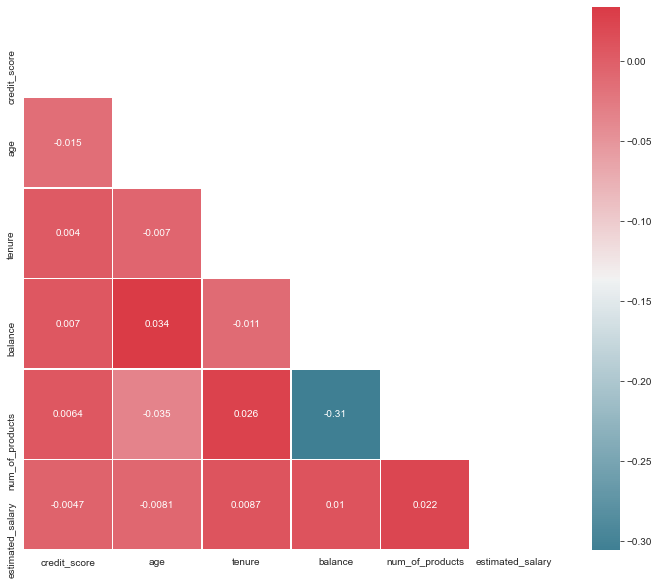

In [103]:
# Calculates the correlations
correlations = num_var1.corr(method='pearson')

# Uses the variable ax for single a Axes
fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(12,10)

# Generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# Generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=0.5, annot=True)

# Display the plot
plt.show()

**Relevant Correlations:**

- `balance` and `num_of_products`: **-0.31**.

### 4.3.2 Categorical Variables

In [104]:
cat_var3 = df4.select_dtypes(include=['object'])
cat_var3 = cat_var3.drop(['exited'], axis=1)

In [105]:
cat_var3.columns

Index(['geography', 'gender', 'has_cr_card', 'is_active_member', 'age_group',
       'estimated_salary_range', 'balance_tenure', 'balance_active',
       'has_cr_card_active_member', 'tenure_has_cr_card',
       'tenure_is_active_member'],
      dtype='object')

<h3> Cramer V Applying </h3>

In [106]:
# Combinations between categorical variables
a1 = cramer_v(cat_var3['geography'], cat_var3['geography'])
a2 = cramer_v(cat_var3['geography'], cat_var3['gender'])
a3 = cramer_v(cat_var3['geography'], cat_var3['has_cr_card'])
a4 = cramer_v(cat_var3['geography'], cat_var3['is_active_member'])
a5 = cramer_v(cat_var3['geography'], cat_var3['age_group'])
a6 = cramer_v(cat_var3['geography'], cat_var3['estimated_salary_range'])
a7 = cramer_v(cat_var3['geography'], cat_var3['balance_tenure'])
a8 = cramer_v(cat_var3['geography'], cat_var3['balance_active'])
a9 = cramer_v(cat_var3['geography'], cat_var3['has_cr_card_active_member'])
a10 = cramer_v(cat_var3['geography'], cat_var3['tenure_has_cr_card'])
a11 = cramer_v(cat_var3['geography'], cat_var3['tenure_is_active_member'])

a12 = cramer_v(cat_var3['gender'], cat_var3['geography'])
a13 = cramer_v(cat_var3['gender'], cat_var3['gender'])
a14 = cramer_v(cat_var3['gender'], cat_var3['has_cr_card'])
a15 = cramer_v(cat_var3['gender'], cat_var3['is_active_member'])
a16 = cramer_v(cat_var3['gender'], cat_var3['age_group'])
a17 = cramer_v(cat_var3['gender'], cat_var3['estimated_salary_range'])
a18 = cramer_v(cat_var3['gender'], cat_var3['balance_tenure'])
a19 = cramer_v(cat_var3['gender'], cat_var3['balance_active'])
a20 = cramer_v(cat_var3['gender'], cat_var3['has_cr_card_active_member'])
a21 = cramer_v(cat_var3['gender'], cat_var3['tenure_has_cr_card'])
a22 = cramer_v(cat_var3['gender'], cat_var3['tenure_is_active_member'])

a23 = cramer_v(cat_var3['has_cr_card'], cat_var3['geography'])
a24 = cramer_v(cat_var3['has_cr_card'], cat_var3['gender'])
a25 = cramer_v(cat_var3['has_cr_card'], cat_var3['has_cr_card'])
a26 = cramer_v(cat_var3['has_cr_card'], cat_var3['is_active_member'])
a27 = cramer_v(cat_var3['has_cr_card'], cat_var3['age_group'])
a28 = cramer_v(cat_var3['has_cr_card'], cat_var3['estimated_salary_range'])
a29 = cramer_v(cat_var3['has_cr_card'], cat_var3['balance_tenure'])
a30 = cramer_v(cat_var3['has_cr_card'], cat_var3['balance_active'])
a31 = cramer_v(cat_var3['has_cr_card'], cat_var3['has_cr_card_active_member'])
a32 = cramer_v(cat_var3['has_cr_card'], cat_var3['tenure_has_cr_card'])
a33 = cramer_v(cat_var3['has_cr_card'], cat_var3['tenure_is_active_member'])

a34 = cramer_v(cat_var3['is_active_member'], cat_var3['geography'])
a35 = cramer_v(cat_var3['is_active_member'], cat_var3['gender'])
a36 = cramer_v(cat_var3['is_active_member'], cat_var3['has_cr_card'])
a37 = cramer_v(cat_var3['is_active_member'], cat_var3['is_active_member'])
a38 = cramer_v(cat_var3['is_active_member'], cat_var3['age_group'])
a39 = cramer_v(cat_var3['is_active_member'], cat_var3['estimated_salary_range'])
a40 = cramer_v(cat_var3['is_active_member'], cat_var3['balance_tenure'])
a41 = cramer_v(cat_var3['is_active_member'], cat_var3['balance_active'])
a42 = cramer_v(cat_var3['is_active_member'], cat_var3['has_cr_card_active_member'])
a43 = cramer_v(cat_var3['is_active_member'], cat_var3['tenure_has_cr_card'])
a44 = cramer_v(cat_var3['is_active_member'], cat_var3['tenure_is_active_member'])

a45 = cramer_v(cat_var3['age_group'], cat_var3['geography'])
a46 = cramer_v(cat_var3['age_group'], cat_var3['gender'])
a47 = cramer_v(cat_var3['age_group'], cat_var3['has_cr_card'])
a48 = cramer_v(cat_var3['age_group'], cat_var3['is_active_member'])
a49 = cramer_v(cat_var3['age_group'], cat_var3['age_group'])
a50 = cramer_v(cat_var3['age_group'], cat_var3['estimated_salary_range'])
a51 = cramer_v(cat_var3['age_group'], cat_var3['balance_tenure'])
a52 = cramer_v(cat_var3['age_group'], cat_var3['balance_active'])
a53 = cramer_v(cat_var3['age_group'], cat_var3['has_cr_card_active_member'])
a54 = cramer_v(cat_var3['age_group'], cat_var3['tenure_has_cr_card'])
a55 = cramer_v(cat_var3['age_group'], cat_var3['tenure_is_active_member'])

a56 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['geography'])
a57 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['gender'])
a58 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['has_cr_card'])
a59 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['is_active_member'])
a60 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['age_group'])
a61 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['estimated_salary_range'])
a62 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['balance_tenure'])
a63 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['balance_active'])
a64 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['has_cr_card_active_member'])
a65 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['tenure_has_cr_card'])
a66 = cramer_v(cat_var3['estimated_salary_range'], cat_var3['tenure_is_active_member'])

a67 = cramer_v(cat_var3['balance_tenure'], cat_var3['geography'])
a68 = cramer_v(cat_var3['balance_tenure'], cat_var3['gender'])
a69 = cramer_v(cat_var3['balance_tenure'], cat_var3['has_cr_card'])
a70 = cramer_v(cat_var3['balance_tenure'], cat_var3['is_active_member'])
a71 = cramer_v(cat_var3['balance_tenure'], cat_var3['age_group'])
a72 = cramer_v(cat_var3['balance_tenure'], cat_var3['estimated_salary_range'])
a73 = cramer_v(cat_var3['balance_tenure'], cat_var3['balance_tenure'])
a74 = cramer_v(cat_var3['balance_tenure'], cat_var3['balance_active'])
a75 = cramer_v(cat_var3['balance_tenure'], cat_var3['has_cr_card_active_member'])
a76 = cramer_v(cat_var3['balance_tenure'], cat_var3['tenure_has_cr_card'])
a77 = cramer_v(cat_var3['balance_tenure'], cat_var3['tenure_is_active_member'])

a78 = cramer_v(cat_var3['balance_active'], cat_var3['geography'])
a79 = cramer_v(cat_var3['balance_active'], cat_var3['gender'])
a80 = cramer_v(cat_var3['balance_active'], cat_var3['has_cr_card'])
a81 = cramer_v(cat_var3['balance_active'], cat_var3['is_active_member'])
a82 = cramer_v(cat_var3['balance_active'], cat_var3['age_group'])
a83 = cramer_v(cat_var3['balance_active'], cat_var3['estimated_salary_range'])
a84 = cramer_v(cat_var3['balance_active'], cat_var3['balance_tenure'])
a85 = cramer_v(cat_var3['balance_active'], cat_var3['balance_active'])
a86 = cramer_v(cat_var3['balance_active'], cat_var3['has_cr_card_active_member'])
a87 = cramer_v(cat_var3['balance_active'], cat_var3['tenure_has_cr_card'])
a88 = cramer_v(cat_var3['balance_active'], cat_var3['tenure_is_active_member'])

a89 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['geography'])
a90 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['gender'])
a91 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['has_cr_card'])
a92 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['is_active_member'])
a93 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['age_group'])
a94 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['estimated_salary_range'])
a95 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['balance_tenure'])
a96 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['balance_active'])
a97 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['has_cr_card_active_member'])
a98 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['tenure_has_cr_card'])
a99 = cramer_v(cat_var3['has_cr_card_active_member'], cat_var3['tenure_is_active_member'])

a100 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['geography'])
a101 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['gender'])
a102 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['has_cr_card'])
a103 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['is_active_member'])
a104 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['age_group'])
a105 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['estimated_salary_range'])
a106 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['balance_tenure'])
a107 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['balance_active'])
a108 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['has_cr_card_active_member'])
a109 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['tenure_has_cr_card'])
a110 = cramer_v(cat_var3['tenure_has_cr_card'], cat_var3['tenure_is_active_member'])

a111 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['geography'])
a112 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['gender'])
a113 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['has_cr_card'])
a114 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['is_active_member'])
a115 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['age_group'])
a116 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['estimated_salary_range'])
a117 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['balance_tenure'])
a118 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['balance_active'])
a119 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['has_cr_card_active_member'])
a120 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['tenure_has_cr_card'])
a121 = cramer_v(cat_var3['tenure_is_active_member'], cat_var3['tenure_is_active_member'])

# Dataset of the correlations
d = pd.DataFrame({'geography': [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11],
                  'gender' : [a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22],
                  'has_cr_card' :[a23, a24, a25, a26, a27, a28, a29, a30, a31, a32, a33],
                  'is_active_member' : [a34, a35, a36, a37, a38, a39, a40, a41, a42, a43, a44],
                  'age_group': [a45, a46, a47, a48, a49, a50, a51, a52, a53, a54, a55],
                  'estimated_salary_range': [a56, a57, a58, a59, a60, a61, a62, a63, a64, a65, a66],
                  'balance_tenure' : [a67, a68, a69, a70, a71, a72, a73, a74, a75, a76, a77],
                  'balance_active' : [a78, a79, a80, a81, a82, a83, a84, a85, a86, a87, a88],
                  'has_cr_card_active_member' : [a89, a90, a91, a92, a93, a94, a95, a96, a97, a98, a99],
                  'tenure_has_cr_card' : [a100, a101, a102, a103, a104, a105, a106, a107, a108, a109, a110],
                  'tenure_is_active_member': [a111, a112, a113, a114, a115, a116, a117, a118, a119, a120, a121]
                 })

# Index equal to columns
d= d.set_index(d.columns)

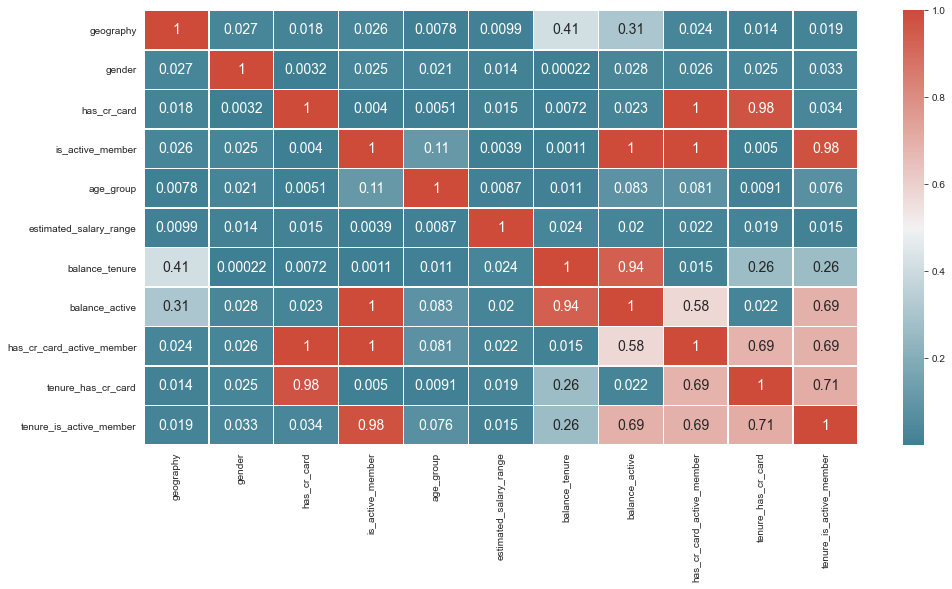

In [107]:
# uses the ax variable for a single axis
fig, ax = plt.subplots()

# Figure size
ax.figure.set_size_inches(16,8)

# Generates a custom diverging colormap
cmap = sns.diverging_palette(220, 16, as_cmap=True)

# Plotting HeatMap
sns.heatmap(d, annot=True, cmap=cmap, linewidths= 0.5, annot_kws={'fontsize':14})

# Display the plot
plt.show()

**Relevant Correlations:**

 - `geography` and `balance`: **0.41**
 
 - `geography` and `balance_active`: **0.31**
 
 - `has_cr_card` and `has_cr_card_active_member`: **1**
 
 - `has_cr_card` and `tenure_has_cr_card`: **0.98**
 
 - `is_active_member` and `balance_active`: **1**
 
 - `is_active_member` and `has_cr_card_active_member`: **1**
 
 - `is_active_member` and `tenure_is_active_member`: **0.98**
 
 - `balance_tenure` and `balance_active`: **0.94**
 
 - `balance_active` and `has_cr_card_active_member`: **0.58**
 
 - `balance_active` and `tenure_is_active_member` : **0.69**
 
 - `has_cr_card_active_member` and `tenure_has_cr_card`: **0.69**
 
 - `has_cr_card_active_member` and `tenure_is_active_member`: **0.69**
 
 - `tenure_has_cr_card` and `tenure_is_active_member` : **0.71**

### 4.3.3 Numerical Variables and Binary Variables

In [108]:
bin_var = df4.select_dtypes(include='object')
bin_var = df4[['has_cr_card', 'is_active_member', 'exited']]

In [109]:
has_cr_card_dict = {'yes': 1, 'no' : 0}
is_active_member_dict = {'yes': 1, 'no': 0}
exited_dict = {'yes': 1, 'no': 0}

# Transformation variables for binary numbers
bin_var['has_cr_card'] = bin_var['has_cr_card'].map(has_cr_card_dict)
bin_var['is_active_member'] = bin_var['is_active_member'].map(is_active_member_dict)
bin_var['exited'] = bin_var['exited'].map(exited_dict)

In [110]:
num_var1.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'estimated_salary'],
      dtype='object')

In [111]:
# Makes all possible combinations between attributes
b1 = pointbiserialr(bin_var['has_cr_card'], num_var1['credit_score'])[0]
b2 = pointbiserialr(bin_var['has_cr_card'], num_var1['age'])[0]
b3 = pointbiserialr(bin_var['has_cr_card'], num_var1['balance'])[0]
b4 = pointbiserialr(bin_var['has_cr_card'], num_var1['num_of_products'])[0]
b5 = pointbiserialr(bin_var['has_cr_card'], num_var1['estimated_salary'])[0]

b6 = pointbiserialr(bin_var['is_active_member'], num_var1['credit_score'])[0]
b7 = pointbiserialr(bin_var['is_active_member'], num_var1['age'])[0]
b8 = pointbiserialr(bin_var['is_active_member'], num_var1['balance'])[0]
b9 = pointbiserialr(bin_var['is_active_member'], num_var1['num_of_products'])[0]
b10 = pointbiserialr(bin_var['is_active_member'], num_var1['estimated_salary'])[0]

b11 = pointbiserialr(bin_var['exited'], num_var1['credit_score'])[0]
b12 = pointbiserialr(bin_var['exited'], num_var1['age'])[0]
b13 = pointbiserialr(bin_var['exited'], num_var1['balance'])[0]
b14 = pointbiserialr(bin_var['exited'], num_var1['num_of_products'])[0]
b15 = pointbiserialr(bin_var['exited'], num_var1['estimated_salary'])[0]

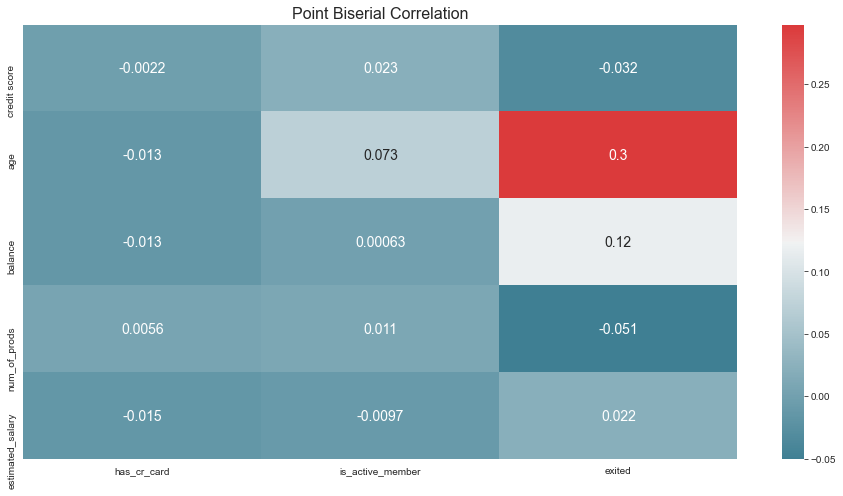

In [112]:
# creates a DataFrame to store the values
df_pbs_r = pd.DataFrame({'has_cr_card':[b1, b2, b3, b4, b5],
                         'is_active_member':[b6, b7, b8, b9, b10],
                         'exited':[b11, b12, b13, b14, b15]}, index=['credit score', 'age', 'balance', 'num_of_prods',
                                                                    'estimated_salary'])
                        
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

cmap = sns.diverging_palette(220, 12, as_cmap=True)

# plots the heatmap
ax = sns.heatmap(df_pbs_r, annot=True, annot_kws={"fontsize":14}, cmap=cmap)
plt.title("Point Biserial Correlation", fontsize=16)


# displays plot
plt.show()

**Relevant correlations:**

- `age`and `exited`: **0.30**
- `balance`and `exited`: **0.12**

In [113]:
df4.head()

row_number  credit_score geography  gender  age  tenure    balance  \
0        2152           753    France    Male   57       7       0.00   
1        8393           739   Germany    Male   32       3  102128.27   
2        5007           755   Germany  Female   37       0  113865.23   
3        4118           561    France    Male   37       5       0.00   
4        7183           692   Germany    Male   49       6  110540.43   

   num_of_products has_cr_card is_active_member  estimated_salary exited  \
0                1         yes               no         159475.08    yes   
1                1         yes               no          63981.37    yes   
2                2         yes              yes         117396.25     no   
3                2         yes               no          83093.25     no   
4                2          no              yes         107472.99     no   

  age_group estimated_salary_range balance_tenure balance_active  \
0     adult                   high    only tenure             no   
1     adult                   high            yes   only balance   
2     adult                   high    only tenure            yes   
3     adult                   high    only tenure             no   
4     adult                   high            yes            yes   

  has_cr_card_active_member tenure_has_cr_card tenure_is_active_member  
0          only credit card                yes             only tenure  
1          only credit card                yes             only tenure  
2                       yes   only credit card      only active member  
3          only credit card                yes             only tenure  
4        only active member        only tenure                     yes

In [114]:
# Remove variables
df4 = df4.drop(['row_number'], axis=1)

# 5.0 Data Preparation

At this stage, we will do the data preparation, which is the data modeling for the model training. The reason for this is that learning most machine learning algorithms is facilitated with numerical data on the same scale.

In [115]:
# Saving the copy of the data
df5 = df4.copy()

In [116]:
# visualization of the data set
df5.head()

credit_score geography  gender  age  tenure    balance  num_of_products  \
0           753    France    Male   57       7       0.00                1   
1           739   Germany    Male   32       3  102128.27                1   
2           755   Germany  Female   37       0  113865.23                2   
3           561    France    Male   37       5       0.00                2   
4           692   Germany    Male   49       6  110540.43                2   

  has_cr_card is_active_member  estimated_salary exited age_group  \
0         yes               no         159475.08    yes     adult   
1         yes               no          63981.37    yes     adult   
2         yes              yes         117396.25     no     adult   
3         yes               no          83093.25     no     adult   
4          no              yes         107472.99     no     adult   

  estimated_salary_range balance_tenure balance_active  \
0                   high    only tenure             no   
1                   high            yes   only balance   
2                   high    only tenure            yes   
3                   high    only tenure             no   
4                   high            yes            yes   

  has_cr_card_active_member tenure_has_cr_card tenure_is_active_member  
0          only credit card                yes             only tenure  
1          only credit card                yes             only tenure  
2                       yes   only credit card      only active member  
3          only credit card                yes             only tenure  
4        only active member        only tenure                     yes

<h3> Converting some data </h3>

In [117]:
df5['gender'] = df5['gender'].apply(lambda x: 1 if x== 'Female' else 2)

df5['has_cr_card'] = df5['has_cr_card'].apply(lambda x: 1 if x=='yes' else 0)

df5['is_active_member'] = df5['is_active_member'].apply(lambda x: 1 if x=='yes' else 0)

df5['exited'] = df5['exited'].apply(lambda x: 1 if x=='yes' else 0)

In [118]:
# geography - Ordinal Encoder
geography_dict = {'France': 1, 'Germany': 2, 'Spain': 3}
df5['geography'] = df5['geography'].map(geography_dict)

# age - Ordinal Encoder
age_dict = {'young' : 1, 'adult': 2,'old' : 3}
df5['age_group'] = df5['age_group'].map(age_dict)

# Estimated Salary Range - Ordinal Encoder
estimated_salary_dict = {'low': 1, 'medium': 2, 'high': 3}
df5['estimated_salary_range'] = df5['estimated_salary_range'].map(estimated_salary_dict)

# Balance Tenure - Ordinal Encoder
balance_tenure_dict = {'yes' : 1, 'only tenure' : 2 }
df5['balance_tenure'] = df5['balance_tenure'].map(balance_tenure_dict)

# Balance Active - Ordinal Encoder
balance_active_dict= {'yes': 1, 'only balance': 2, 'only active member': 3, 'no': 4}
df5['balance_active'] = df5['balance_active'].map(balance_active_dict)

# Has Cr Card Active Member - Ordinal Encoder
has_cr_card_active_member_dict = {'yes': 1, 'only credit card' : 2, 'only active member' : 3, 'no' : 4}
df5['has_cr_card_active_member'] = df5['has_cr_card_active_member'].map(has_cr_card_active_member_dict)

# tenure has cr card - Ordinal Encoder
tenure_has_cr_card_dict = {'yes': 1, 'only tenure' : 2, 'only credit card' : 3}
df5['tenure_has_cr_card'] = df5['tenure_has_cr_card'].map(tenure_has_cr_card_dict)

# Tenure is active member - Ordinal Encoder
tenure_is_active_member_dict = {'yes': 1, 'only tenure' : 2, 'only active member' : 3}
df5['tenure_is_active_member'] = df5['tenure_is_active_member'].map(tenure_is_active_member_dict)

## 5.1 Normalization

Observing  the univariate analysis section, there are not variables with normal distribution.

## 5.2 Rescale

In [119]:
# Selecting Numerical Variables
numerical = df5.select_dtypes(exclude='object')

In [120]:
# Listing columns
numerical.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'age_group', 'estimated_salary_range',
       'balance_tenure', 'balance_active', 'has_cr_card_active_member',
       'tenure_has_cr_card', 'tenure_is_active_member'],
      dtype='object')

In [121]:
# Rescale Methods
rs = RobustScaler()
mms = MinMaxScaler()

### 5.2.1 Credit Score

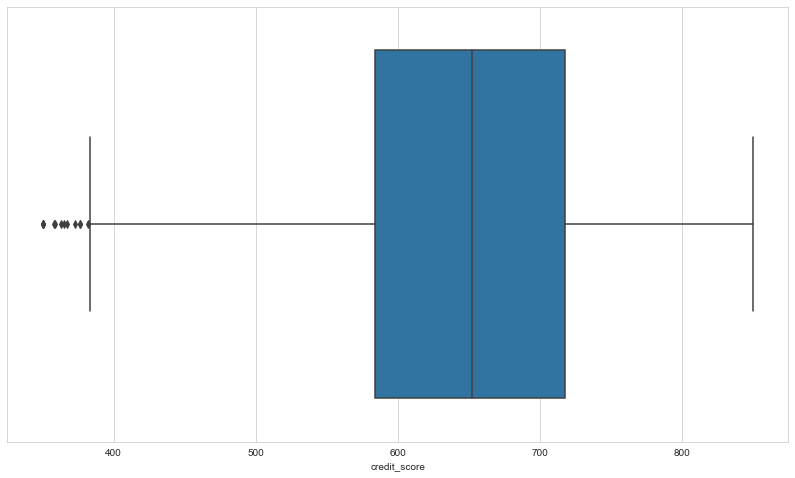

In [122]:
# Plotting boxplot to check outliers

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Plotting boxplot
gr = sns.boxplot(df5['credit_score'])

# Display the plotting
plt.show()

**Observation:**

- Looking at the boxplot above, we see that the `credit_score` variable has few outliers. Therefore, we will to use Robustscaler() function.

In [123]:
# Credit Score - RobustScaler()
df5['credit_score'] = rs.fit_transform(df5[['credit_score']].values)

### 5.2.2 Age

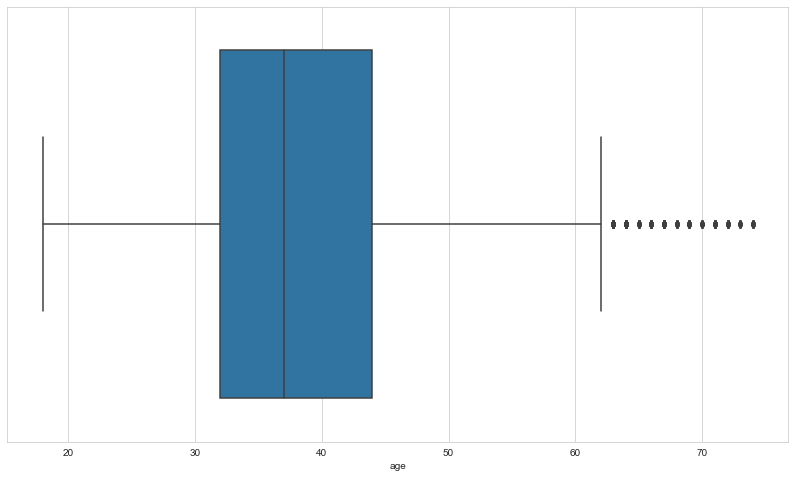

In [124]:
# Plotting boxplot to check outliers

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Plotting boxplot
gr = sns.boxplot(df5['age'])

# Display the plotting
plt.show()

**Observation:**

- Looking at the boxplot above, we see that the `age` variable has few outliers. Therefore, we will to use RobustScaler() function.

In [125]:
# Age - minmaxscaler()
df5['age'] = rs.fit_transform(df5[['age']].values)

### 5.2.3 Balance

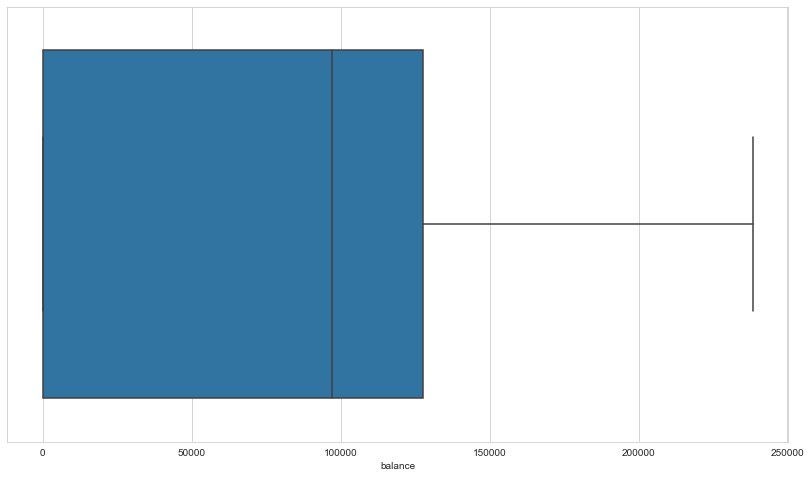

In [126]:
# Plotting boxplot to check outliers

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Plotting boxplot
gr = sns.boxplot(df5['balance'])

# Display the plotting
plt.show()

**Observation:**

- Looking at the boxplot above, we see that the variable "balance" has no outliers. Therefore, let's use the MinMaxScaler() function.

In [127]:
df5['balance'] = mms.fit_transform(df5[['balance']].values)

### 5.2.4 Number of Products

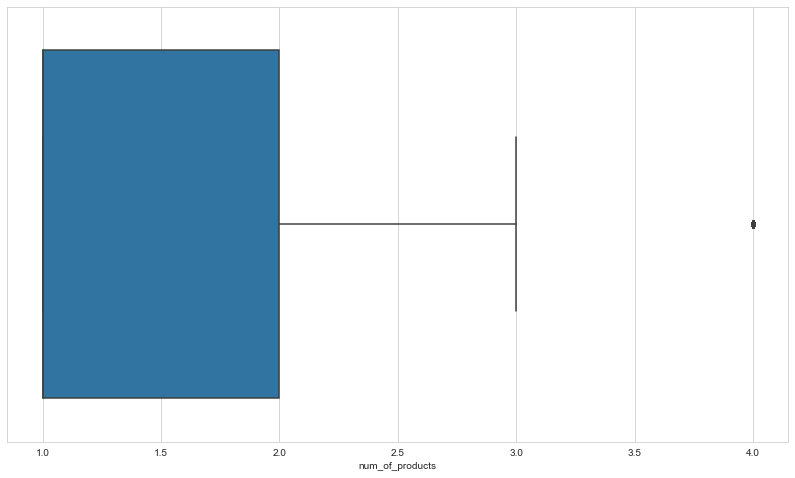

In [128]:
# Plotting boxplot to check outliers

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Plotting boxplot
gr = sns.boxplot(df5['num_of_products'])

# Display the plotting
plt.show()

**Observation:**

- Looking at the boxplot above, we see that the variable `num_of_products` has only one outlier. Therefore, let's use the MaxMinScaler() function.

In [129]:
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)

### 5.2.5 Estimated Salary

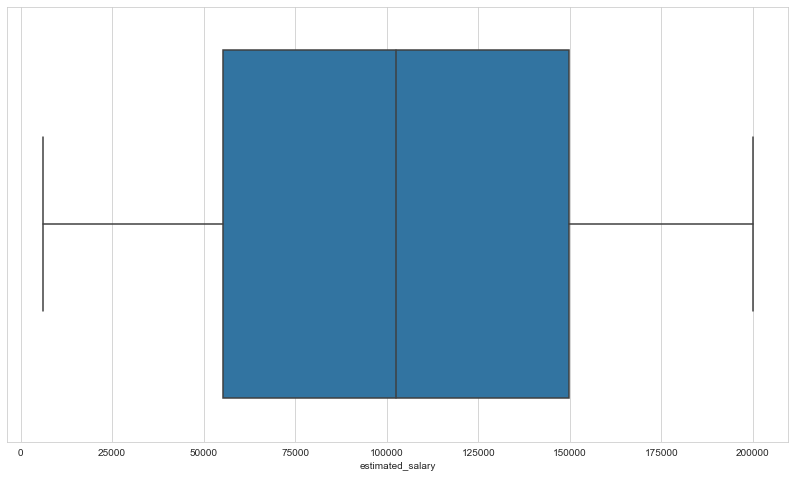

In [130]:
# Plotting boxplot to check outliers

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Plotting boxplot
gr = sns.boxplot(df5['estimated_salary'])

# Display the plotting
plt.show()

**Observation:**

- Looking at the boxplot above, we see that the variable `estimated_salary` has not outliers. Therefore, let's use the MinMaxScaler() function.

In [131]:
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)

### 5.2.6 Tenury

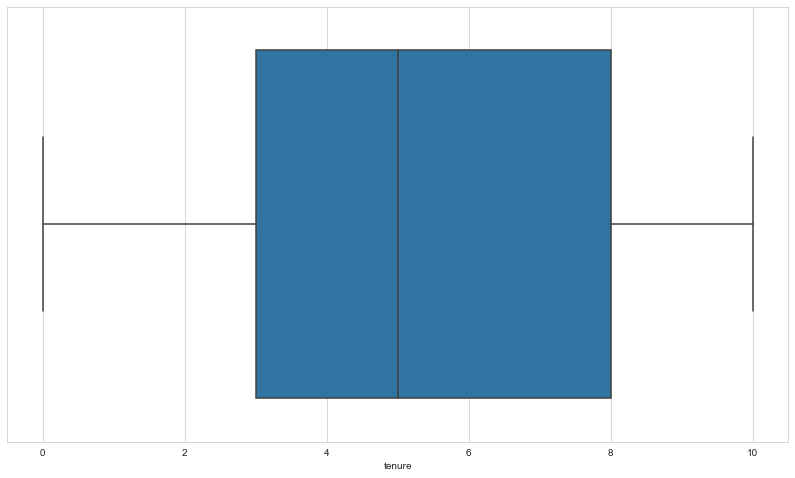

In [132]:
# Plotting boxplot to check outliers

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(14,8)

# Plotting boxplot
gr = sns.boxplot(df5['tenure'])

# Display the plotting
plt.show()

**Observation:**

- Looking at the boxplot above, we see that the variable `tenury` has not outliers. Therefore, let's use the MinMaxScaler() function.

In [133]:
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)

In [134]:
# Visualization of the data set
df5.head()

credit_score  geography  gender       age  tenure   balance  \
0      0.753731          1       2  1.666667     0.7  0.000000   
1      0.649254          2       2 -0.416667     0.3  0.428413   
2      0.768657          2       1  0.000000     0.0  0.477648   
3     -0.679104          1       2  0.000000     0.5  0.000000   
4      0.298507          2       2  1.000000     0.6  0.463700   

   num_of_products  has_cr_card  is_active_member  estimated_salary  exited  \
0         0.000000            1                 0          0.791101       1   
1         0.000000            1                 0          0.298756       1   
2         0.333333            1                 1          0.574152       0   
3         0.333333            1                 0          0.397293       0   
4         0.333333            0                 1          0.522990       0   

   age_group  estimated_salary_range  balance_tenure  balance_active  \
0          2                       3               2               4   
1          2                       3               1               2   
2          2                       3               2               1   
3          2                       3               2               4   
4          2                       3               1               1   

   has_cr_card_active_member  tenure_has_cr_card  tenure_is_active_member  
0                          2                   1                        2  
1                          2                   1                        2  
2                          1                   3                        3  
3                          2                   1                        2  
4                          3                   2                        1

# 6.0 Feature Selection

In this module 06, we will make the feature selection. This process is important to facilitate the understanding of machine learning algorithms.

In [135]:
# Saving copy of the data
df6 = df5.copy()

## 6.1 Spliting Dependents Variables and Target Variable

In [136]:
# Dependents Variables
x_train = df6.drop(['exited'], axis=1)

# Target Variable
y_train = df6['exited'].copy()

In [137]:
# Dimensions of the Data
x_train.shape, y_train.shape 

((7714, 17), (7714,))

## 6.2 Random Forest as Feature Selector

In [138]:
# train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': x_train.columns,
    'feature importance': rf.feature_importances_}).sort_values('feature importance', ascending=False).reset_index(drop=True)

<AxesSubplot:xlabel='feature importance', ylabel='feature'>

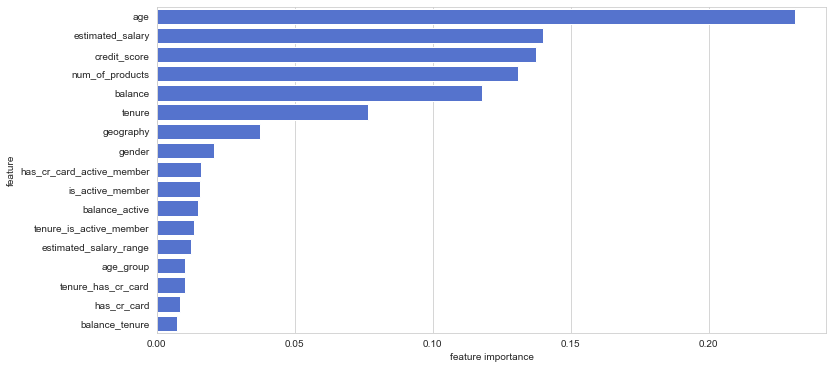

In [139]:
# Plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x = 'feature importance', y='feature', data=feat_imp, orient='h', color='royalblue')

In [140]:
feat_imp_select = feat_imp.iloc[:8]
feat_imp_select

feature  feature importance
0               age            0.231012
1  estimated_salary            0.139925
2      credit_score            0.137453
3   num_of_products            0.130862
4           balance            0.117845
5            tenure            0.076653
6         geography            0.037504
7            gender            0.020742

## 6.3 Manual Feature Selection

Although Random Forest selects the best features, we will add more features that we consider important based on business understanding. Therefore, we will verify the relevancy of the hypotheses made in the Exploratory Data Analysis.

In [141]:
feat_imp_select['feature'].to_list()

['age',
 'estimated_salary',
 'credit_score',
 'num_of_products',
 'balance',
 'tenure',
 'geography',
 'gender']

In [142]:
# Manual feature select 
manual_feature_selection = ['age','estimated_salary','credit_score','num_of_products','balance','tenure','geography','gender',
                           'balance_active','has_cr_card_active_member', 'tenure_is_active_member']

In [143]:
manual_feature_selection

['age',
 'estimated_salary',
 'credit_score',
 'num_of_products',
 'balance',
 'tenure',
 'geography',
 'gender',
 'balance_active',
 'has_cr_card_active_member',
 'tenure_is_active_member']

# 7.0 Machine Learning Modeling

In this module, we will finally apply the Machine Learning models in which the motivation to use these algorithms is to build an intelligent model that is able to determine the **probability** of each customer going into **churn or not**. For this, we will use supervised task classification algorithms such as:

- Logistic Regression
- Random Forest Classification
- Catboost Classifier
- LGBM Classifier 
- BernoulliNB
- KNeighbors Classifier
- XGBoost Classifier


However, first of all, we will separate the data based on the features chosen in step 6.

In [144]:
# Using columns selected by Random Forest in the training data.
x_train = x_train[manual_feature_selection]
x_train.head()

age  estimated_salary  credit_score  num_of_products   balance  \
0  1.666667          0.791101      0.753731         0.000000  0.000000   
1 -0.416667          0.298756      0.649254         0.000000  0.428413   
2  0.000000          0.574152      0.768657         0.333333  0.477648   
3  0.000000          0.397293     -0.679104         0.333333  0.000000   
4  1.000000          0.522990      0.298507         0.333333  0.463700   

   tenure  geography  gender  balance_active  has_cr_card_active_member  \
0     0.7          1       2               4                          2   
1     0.3          2       2               2                          2   
2     0.0          2       1               1                          1   
3     0.5          1       2               4                          2   
4     0.6          2       2               1                          3   

   tenure_is_active_member  
0                        2  
1                        2  
2                        3  
3                        2  
4                        1

## 7.1 Machine Learning Model Training

### 7.1.1 Logistic Regression

In [145]:
# model
lr = LogisticRegression()

# fit the model
lr.fit(x_train, y_train)

# model with performance function
lr_performance = performance(lr, x_train, y_train)
lr_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.802695        0.568531     0.164033       0.253619   

   test_roc_auc_score  
0            0.565552

In [146]:
# predictions
lr_y_pred = cross_val_predict(lr, x_train, y_train, cv=10)

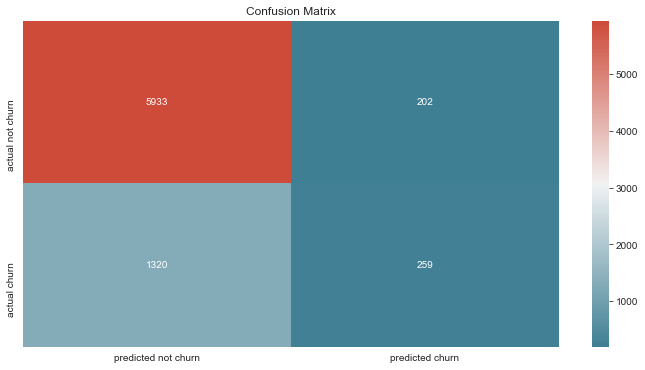

In [147]:
# Confusion Matrix
lr_cm = confusion_matrix(y_train, lr_y_pred)

# Dataframe for Heatmap
lr_cm_df = pd.DataFrame(lr_cm, columns=['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'] )

fig, gr = plt.subplots()

# Figure Size
gr.figure.set_size_inches(12,6)

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

# Confusion matrix heatmap
gr = sns.heatmap(lr_cm_df, annot=True, fmt='g', cmap=cmap).set_title('Confusion Matrix');

### 7.1.2 Random Forest Classifier

In [148]:
# Define and fit the model
rfcl = RandomForestClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

# model with performance function
rfc_performance = performance(rfcl, x_train, y_train)
rfc_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.860513        0.780133     0.444606       0.565574   

   test_roc_auc_score  
0            0.706084

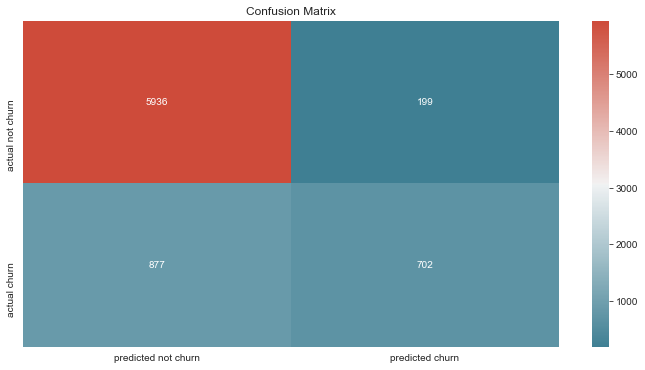

In [149]:
# predictions
rfc_y_pred = cross_val_predict(rfcl, x_train, y_train, cv=10)

# Confusion Matrix
rfc_cm = confusion_matrix(y_train, rfc_y_pred)

# Dataframe for Heatmap
rfc_cm_df = pd.DataFrame(rfc_cm, columns=['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

fig, gr = plt.subplots()

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

# Figure Size
gr.figure.set_size_inches(12,6)

# Confusion matrix heatmap
gr = sns.heatmap(rfc_cm_df, annot=True, fmt='g', cmap=cmap).set_title('Confusion Matrix');

### 7.1.3 Catboost Classifier

In [150]:
# Model
cat = CatBoostClassifier(random_state=42, verbose=False).fit(x_train, y_train)

# model with performance function
cat_performance = performance(cat, x_train, y_train)
cat_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.862069        0.759532     0.478154       0.586178   

   test_roc_auc_score  
0            0.719516

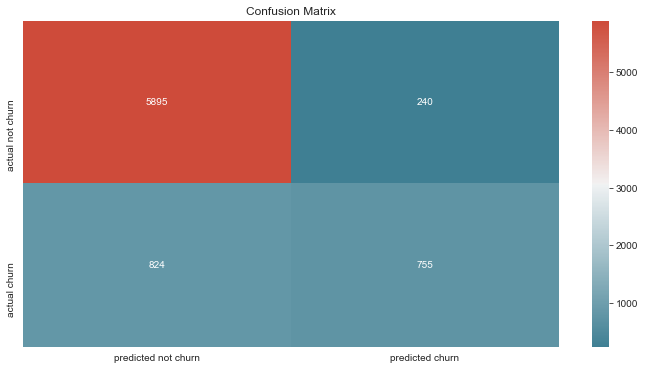

In [151]:
# predictions
cat_y_pred = cross_val_predict(cat, x_train, y_train, cv=10)

# Confusion Matrix
cat_cm = confusion_matrix(y_train, cat_y_pred)

# Dataframe for Heatmap
cat_cm_df = pd.DataFrame(cat_cm, columns=['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

fig, gr = plt.subplots()

gr.figure.set_size_inches(12,6)

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

# Confusion matrix heatmap
sns.heatmap(cat_cm_df, annot=True, fmt='g', cmap=cmap).set_title('Confusion Matrix');

### 7.1.4 LGBM Classifier

In [152]:
# model
lgbm = LGBMClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

lgbm_performance = performance(lgbm, x_train, y_train)
lgbm_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.863753        0.756746     0.493969       0.596706   

   test_roc_auc_score  
0            0.726446

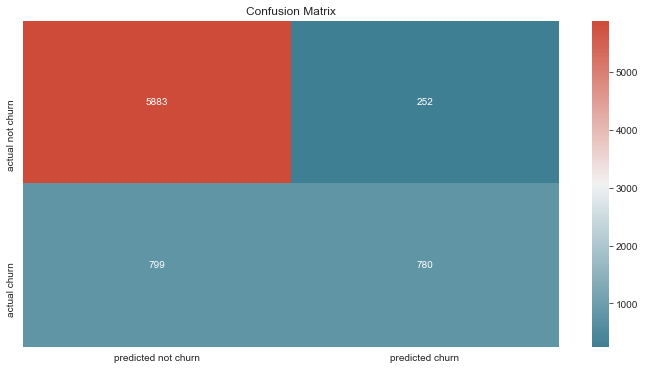

In [153]:
# predictions
lgbm_y_pred = cross_val_predict(lgbm, x_train, y_train, cv=10)

# Confusion Matrix
lgbm_cm = confusion_matrix(y_train, lgbm_y_pred)

# Dataframe for Heatmap
lgbm_cm_df = pd.DataFrame(lgbm_cm, columns=['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

fig, gr = plt.subplots()

gr.figure.set_size_inches(12,6)

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

# Confusion matrix heatmap
sns.heatmap(lgbm_cm_df, annot=True, fmt='g', cmap=cmap).set_title('Confusion Matrix');

### 7.1.5 KNN Classifier

In [154]:
# model
knn = KNeighborsClassifier(n_neighbors=5, weights='distance',n_jobs=-1)

# fit the model
knn.fit(x_train, y_train)

knn_performance = performance(knn, x_train, y_train)
knn_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.821104        0.620712     0.329969       0.429967   

   test_roc_auc_score  
0             0.63874

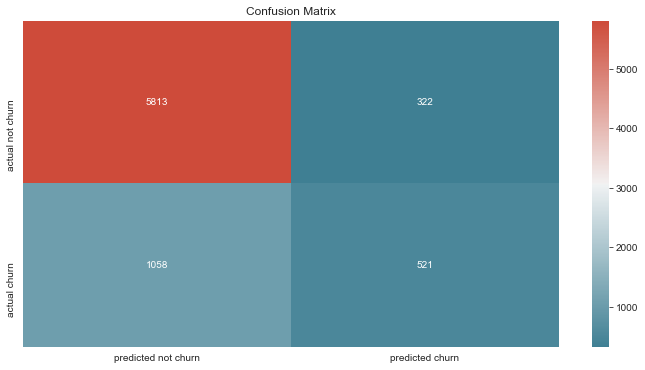

In [155]:
# predictions
knn_y_pred = cross_val_predict(knn, x_train, y_train, cv=10)

# Confusion Matrix
knn_cm = confusion_matrix(y_train, knn_y_pred)

# Dataframe for Heatmap
knn_cm_df = pd.DataFrame(knn_cm, columns=['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

fig, gr = plt.subplots()

gr.figure.set_size_inches(12,6)

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

# Confusion matrix heatmap
sns.heatmap(knn_cm_df, annot=True, fmt='g', cmap=cmap).set_title('Confusion Matrix');

## 7.2 Performance Comparison

In [185]:
# performance comparison data frame
performance_comp = pd.concat([lr_performance, rfc_performance, cat_performance, lgbm_performance, knn_performance])
performance_comp.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
performance_comp['model'] = ['Logistic Regressiom','Random Forest Classifier', 'Catboost Classifier', 'LGBM Classifier', 'KNN']
performance_comp = performance_comp[['model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']]
performance_comp.set_index('model')

Accuracy  Precision    Recall  F1-Score   ROC AUC
model                                                                      
Logistic Regressiom       0.802695   0.568531  0.164033  0.253619  0.565552
Random Forest Classifier  0.860513   0.780133  0.444606  0.565574  0.706084
Catboost Classifier       0.862069   0.759532  0.478154  0.586178  0.719516
LGBM Classifier           0.863753   0.756746  0.493969  0.596706  0.726446
KNN                       0.821104   0.620712  0.329969  0.429967  0.638740

**Observation**

- Based on the Business context and in order to better accomplish the project goals, deliverables and deployment, the chosen model is **LGBM Classifier**.

# 8.0 Hyperparameter Fine-Tuning

## 8.1 Random Search

In [187]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [188]:
# set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [189]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_clf_random = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid,
                              scoring='f1', n_iter=100, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [190]:
# fit the model
rf_clf_random.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 39.9min finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [191]:
rf_clf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None}

In [192]:
rf_clf_random.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [193]:
# Best estimator
rf_tuned = rf_clf_random.best_estimator_
rf_tuned

RandomForestClassifier(min_samples_split=5, n_estimators=500, n_jobs=-1,
                       random_state=42)

## 8.2 Save Model Tuned

In [194]:
# Salvando melhores estimadores
with open('C:/Users/diasn/projeto_aluno/pa003_churn_predict/estimator/rf_best_estimator.pkl', 'wb') as file:
    pi.dump(rf_tuned, file)

In [195]:
# Carregar modelo
with open('C:/Users/diasn/projeto_aluno/pa003_churn_predict/estimator/rf_best_estimator.pkl', 'rb') as f:
    rf_best_tuned = pi.load(f)


In [196]:
rf_best_tuned

RandomForestClassifier(min_samples_split=5, n_estimators=500, n_jobs=-1,
                       random_state=42)

## 8.3 Tuned Model x Base Model Performance Comparison on Test Set

### 8.3.1 Prepare Test Set

In [197]:
# load test set
test_set = pd.read_csv('C:/Users/diasn/projeto_aluno/pa003_churn_predict/data/test_churn')

In [198]:
test_set.head()

Unnamed: 0  RowNumber  CustomerId    Surname  CreditScore Geography  \
0        5702       5703    15749540     Hsiung          585    France   
1        3667       3668    15807340  O'Donnell          525   Germany   
2        1617       1618    15801062   Matthews          557     Spain   
3        5673       5674    15572801  Krischock          639     Spain   
4        4272       4273    15600708  Calabresi          640     Spain   

   Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0    Male   36       7       0.00              2          1               0   
1    Male   33       4  131023.76              2          0               0   
2  Female   40       4       0.00              2          0               1   
3    Male   34       5  139393.19              2          0               0   
4  Female   34       3   77826.80              1          1               1   

   EstimatedSalary  Exited  
0         94283.09       0  
1         55072.93       0  
2        105433.53       0  
3         33950.08       0  
4        168544.85       0

#### 8.3.1.1 Rename Columns

In [199]:
test_set = test_set.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

In [200]:
test_set.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [201]:
# List Columns
cols_old = ['CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inf.underscore(x)

cols_new = list(map(snakecase, cols_old))

test_set.columns = cols_new

#### 8.3.1.2 Feature Engineering

In [202]:
# Age Group
test_set['age_group'] = test_set['age'].apply(lambda x: 'young' if x < 20 else 'adult' if 20 <= x < 60 else 'old' )

# Estimated Salary Range
test_set['estimated_salary_range'] = test_set['estimated_salary'].apply(lambda x: 'low' if x < 13000 else 'medium' if x <= 30000 
                                                              else 'high')

# Balance Tenure
test_set['balance_tenure'] = test_set.apply(lambda x: 'yes' if (x['balance'] > 0) and (x['tenure'] > 0) 
                                  else 'no' if (x['balance'] < 0) and (x['tenure'] < 0)
                                  else 'only balance' if (x['balance'] > 0) and (x['tenure'] < 0)
                                  else 'only tenure', axis=1)

# Balance Active
test_set['balance_active'] = test_set.apply(lambda x: 'yes' if (x['balance'] != 0) and (x['is_active_member']=='yes')
                                  else 'no' if (x['balance']==0) and (x['is_active_member']=='no')
                                  else 'only balance' if (x['balance'] != 0) and (x['is_active_member']=='no')
                                  else 'only active member', axis=1)

# Has cr card active member
test_set['has_cr_card_active_member'] = test_set.apply(lambda x: 'yes' if (x['has_cr_card']=='yes') and (x['is_active_member']=='yes') 
                                   else 'no' if (x['has_cr_card']=='no') and (x['is_active_member']=='no') 
                                   else 'only credit card' if (x['has_cr_card']=='yes') and (x['is_active_member']=='no')
                                   else 'only active member', axis=1)

# tenure cr card active member
test_set['tenure_has_cr_card'] = test_set.apply(lambda x: 'yes' if (x['tenure'] > 0) and (x['has_cr_card']=='yes') 
                                      else 'no' if (x['tenure'] < 0) and (x['has_cr_card']=='no') 
                                      else 'only tenure' if (x['tenure'] > 0) and (x['has_cr_card']=='no') 
                                      else 'only credit card', axis=1)

# tenure is active member
test_set['tenure_is_active_member'] =test_set.apply(lambda x: 'yes' if (x['tenure'] > 0) and (x['is_active_member']=='yes') 
                                          else 'no' if (x['tenure'] < 0) and (x['is_active_member']=='no') 
                                          else 'only tenure' if (x['tenure'] > 0) and (x['is_active_member']=='no') 
                                          else 'only active member', axis=1)

In [203]:
# copy test set
x_test_prep = test_set.copy()

In [204]:
x_test_prep['exited'].value_counts()

0    1593
1     407
Name: exited, dtype: int64

#### 8.3.1.3 Data Preparation

In [205]:
x_test_prep['gender'] = x_test_prep['gender'].apply(lambda x: 1 if x== 'Female' else 2)

In [206]:
# geography - Ordinal Encoder
geography_dict = {'France': 1, 'Germany': 2, 'Spain': 3}
x_test_prep['geography'] = x_test_prep['geography'].map(geography_dict)

# age - Ordinal Encoder
age_dict = {'young' : 1, 'adult': 2,'old' : 3}
x_test_prep['age_group'] = x_test_prep['age_group'].map(age_dict)

# Estimated Salary Range - Ordinal Encoder
estimated_salary_dict = {'low': 1, 'medium': 2, 'high': 3}
x_test_prep['estimated_salary_range'] = x_test_prep['estimated_salary_range'].map(estimated_salary_dict)

# Balance Tenure - Ordinal Encoder
balance_tenure_dict = {'yes' : 1, 'only tenure' : 2 }
x_test_prep['balance_tenure'] = x_test_prep['balance_tenure'].map(balance_tenure_dict)

# Balance Active - Ordinal Encoder
balance_active_dict= {'yes': 1, 'only balance': 2, 'only active member': 3, 'no': 4}
x_test_prep['balance_active'] = x_test_prep['balance_active'].map(balance_active_dict)

# Has Cr Card Active Member - Ordinal Encoder
has_cr_card_active_member_dict = {'yes': 1, 'only credit card' : 2, 'only active member' : 3, 'no' : 4}
x_test_prep['has_cr_card_active_member'] = x_test_prep['has_cr_card_active_member'].map(has_cr_card_active_member_dict)

# tenure has cr card - Ordinal Encoder
tenure_has_cr_card_dict = {'yes': 1, 'only tenure' : 2, 'only credit card' : 3}
x_test_prep['tenure_has_cr_card'] = x_test_prep['tenure_has_cr_card'].map(tenure_has_cr_card_dict)

# Tenure is active member - Ordinal Encoder
tenure_is_active_member_dict = {'yes': 1, 'only tenure' : 2, 'only active member' : 3}
x_test_prep['tenure_is_active_member'] = x_test_prep['tenure_is_active_member'].map(tenure_is_active_member_dict)

In [207]:
# Credit Score - RobustScaler()
x_test_prep['credit_score'] = rs.fit_transform(x_test_prep[['credit_score']].values)

# Age = RobustScaler()
x_test_prep['age'] = rs.fit_transform(x_test_prep[['age']].values)

# Num of products - MinMaxScaler()
x_test_prep['num_of_products'] = mms.fit_transform(x_test_prep[['num_of_products']].values)

# Balance - MinMaxScaler()
x_test_prep['balance'] = mms.fit_transform(x_test_prep[['balance']].values)

# Estimated Salary - MinMaxScaler()
x_test_prep['estimated_salary'] = mms.fit_transform(x_test_prep[['estimated_salary']].values)

# Tenury - MinMaxScaler()
x_test_prep['tenure'] = mms.fit_transform(x_test_prep[['tenure']].values)

In [208]:
# Target Variable
y_test = x_test_prep['exited'].copy()

#### 8.3.1.4 Selected Features List

In [209]:
select_feat = ['age','estimated_salary','credit_score','num_of_products','balance','tenure','geography','gender',
                           'balance_active','has_cr_card_active_member', 'tenure_is_active_member']

# select features on test set
x_test = x_test_prep[select_feat]

In [210]:
y_test.value_counts()

0    1593
1     407
Name: exited, dtype: int64

### 8.2.2 Base Model Performance

In [216]:
# Performance of model trained, pegar modelo que não está tunado
rf_model, cm = performance_test('Random Forest Classifier', rfcl, x_test, y_test)
rf_model

Precision    Recall  F1-Score  ROC AUC Score
Random Forest Classifier   0.653251  0.518428  0.578082        0.72406

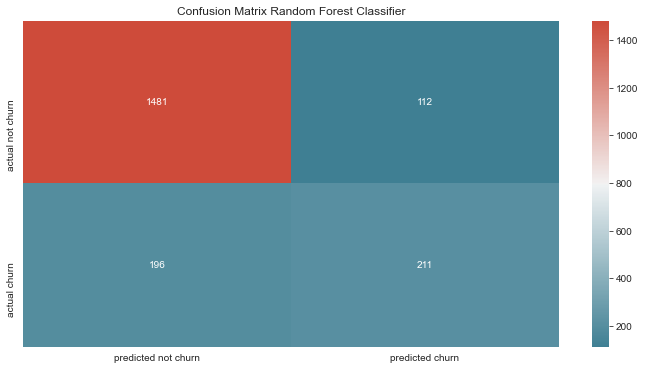

In [212]:
fig, gr = plt.subplots()

gr.figure.set_size_inches(12,6)

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

# confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap).set_title('Confusion Matrix Random Forest Classifier')

plt.show()

### 8.2.3 Tunel Model Performance

In [215]:
rf_model_tuned, cm_rf_tuned = performance_test('Random Forest Classifier Tuned', rf_best_tuned, x_test, y_test)
rf_model_tuned

Precision    Recall  F1-Score  ROC AUC Score
Random Forest Classifer Tuned   0.644172  0.515971  0.572988       0.721576

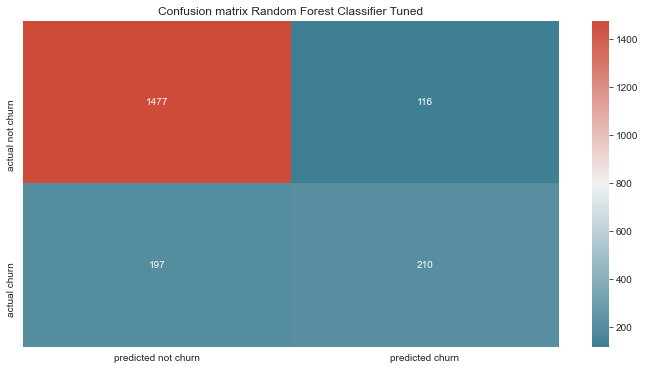

In [214]:
fig, gr = plt.subplots()

gr.figure.set_size_inches(12,6)

cmap = sns.diverging_palette(220, 16, as_cmap=True) 

sns.heatmap(cm_rf_tuned, annot=True, fmt='g', cmap=cmap).set_title('Confusion matrix Random Forest Classifier Tuned')

plt.show()

# 9.0 Model and Business Performance

## 9.1 Model Performance

### 9.1.1 Precision and Recall x Decision Threshold

In [221]:
# calculated model predicted probabilities
y_probs = rfcl.predict_proba(x_test)

# Get positive class probalities
y_scores = y_probs[:,1]
y_scores

array([0.02, 0.13, 0.11, ..., 0.7 , 0.05, 0.11])

In [222]:
# compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

In [225]:
# current recall from the model
recall_model = rf_model['Recall'][0]

# current precision from the model
precision_model = rf_model['Precision'][0]

In [226]:
# Get current precision index 
prec_index = np.where(precisions==precision_model)
prec_index

(array([50], dtype=int64),)

In [227]:
# Gets current threshold of the model
threshold_model = thresholds[prec_index]
threshold_model

array([0.51])

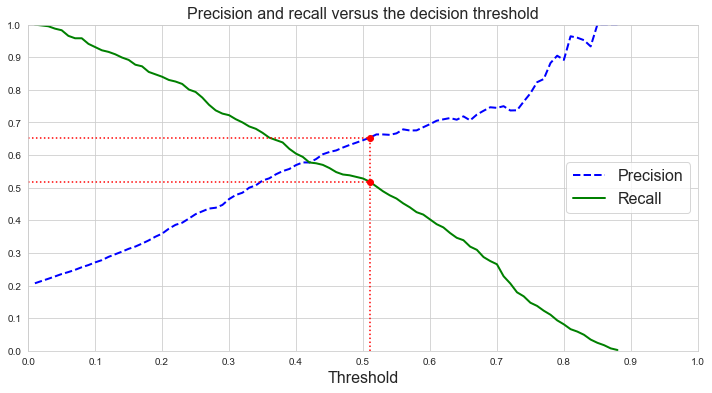

In [228]:
# PLot precision and recall versus threshold
# figure size
plt.figure(figsize=(12,6))

plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.legend(loc='center right', fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.grid(True)

# plot current precision and recall from the model
plt.plot([threshold_model, threshold_model], [0.0, precision_model], 'r:')
plt.plot([0.0, threshold_model], [precision_model, precision_model], 'r:')
plt.plot([0.0, threshold_model], [recall_model, recall_model], 'r:')
plt.plot([threshold_model], [precision_model], 'ro')
plt.plot([threshold_model], [recall_model], 'ro')
plt.axis([0, 1, 0, 1])
plt.title('Precision and recall versus the decision threshold', fontsize=16)
plt.show()

### 9.1.2 Precision and Recall

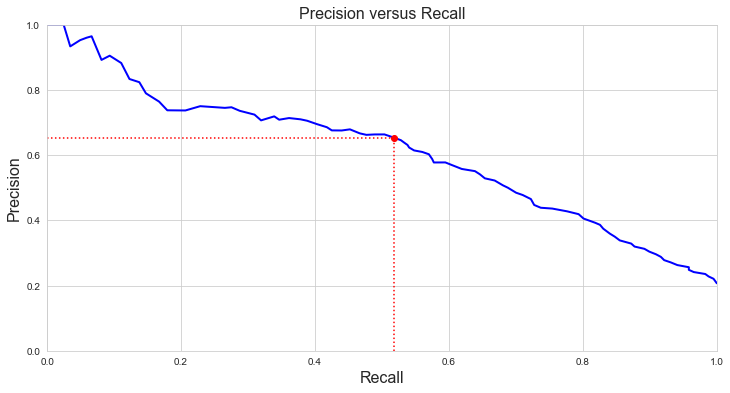

In [229]:
# plot precision versus recall

# figure size
plt.figure(figsize=(12,6))

plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.axis([0, 1, 0, 1])

# plot current precision and recall from the model
plt.plot([recall_model, recall_model], [0.0, precision_model], 'r:')
plt.plot([0.0, recall_model], [precision_model, precision_model], 'r:')
plt.plot([recall_model], [precision_model], 'ro')
plt.grid(True)
plt.title('Precision versus Recall', fontsize=16)
plt.show()

### 9.1.3 Cumulative Gains Curve

- The left hand side of the x-axis start with the observations that have the highest probability of belonging to the class of interest.
- The x axis tell us what percentage of the observations are being considered. In this case, it is a percentage of the 2.000 clients from the test set.
- The y axis (gain) indicates the percentage of positive responses. In this case, it is the percentage of the 407 positive responses from the test set.
- Question to ask and answer with this plot: when the model is applied to the data, and the most likely X percent of the records are selected, what percentage of the actual records you’re interested can you expect to find?

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

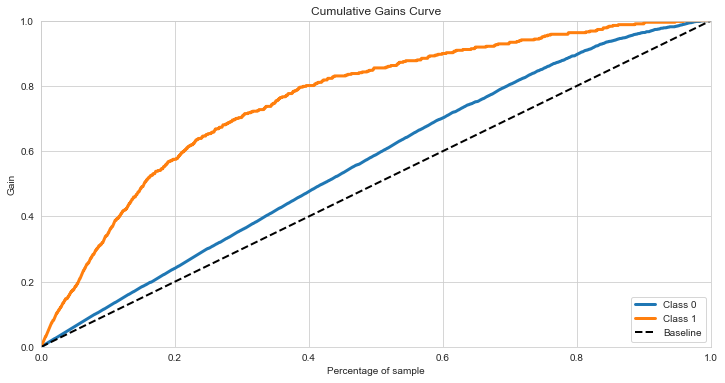

In [230]:
plot_cumulative_gain(y_test, y_probs, figsize=(12,6))

**Observation:**

### 9.1.4 Lift Curve

- The lift curve uses the returned probability of a classification model to assess how the model is performing, and how well it is identifying the positive or negative instances of the dataset.
- By ordering the data from the highest to the smallest probability, the highest probability appear on the left of the graph, usually along with the highest Lift scores.
- Provides a quick way to get an estimate of how the algorithm is performing.
- The lift chart provides an easy way to visualize how many times better applying the model is than random selection for any percentage of the ranked records.
- The greater the area between the lift curve and the baseline, the better the model.

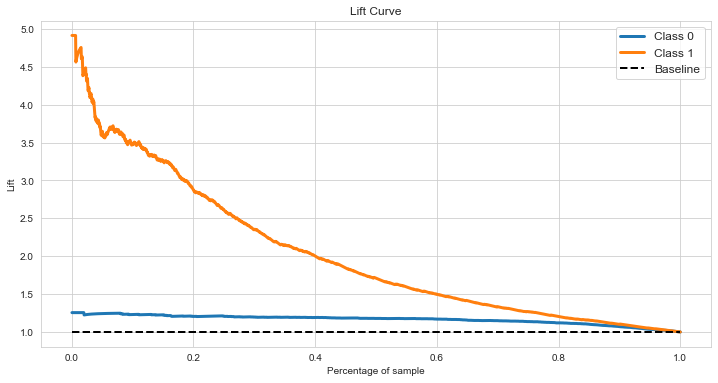

In [231]:
# plot Lift Curve
plot_lift_curve(y_test, y_probs, figsize=(12,6))
plt.legend(fontsize=12)
plt.show()

**Observation:**

- Check Lift and Cumulative Gains values

In [232]:
# copy test set
lift_df = test_set.copy()

# add predictions and predicted probabilities according the model
#lift_df['predictions'] = y_pred
lift_df['probabilities'] = y_scores

# sort lift_df according predicted probabilities
lift_df = lift_df.sort_values('probabilities', ascending=False)

In [233]:
from termcolor import colored

In [234]:
# set percentage of the sample (percentage of clients to contact in order to avoid churn)
sample_pc = 0.2035

# calculate the size of the percentage of the sample
top_sample_pc = np.ceil((len(lift_df['exited'])*sample_pc)).astype(int)

# select top rated clients (top predicted probabilities)
clients_top = lift_df.iloc[:top_sample_pc]

# calculate cumulative gain
cumulative_gain = clients_top['exited'].sum() / test_set['exited'].sum()

# calculate lift
lift = cumulative_gain / sample_pc

# print results
print(colored('Observations:', attrs=['bold']))
print('sample percentage: {:,.2f}%'.format(sample_pc*100))
print('Cumulative gain: {:,.2f}'.format(cumulative_gain))
print('Lift: {:,.2f}'.format(lift))

Observations:
sample percentage: 20.35%
Cumulative gain: 0.58
Lift: 2.84


## 9.2 Business Performance

### 9.2.1 Current Churn Rate ( Taxa de churn atual)

In [235]:
# Calculate current churn rate
churn_rate = test_set['exited'].value_counts(normalize=True)*100
print(colored('Observation:', 'green', attrs=['bold']))
print('The current Churn Rate is {:,.2f}%'.format(churn_rate[1]))

Observation:
The current Churn Rate is 20.35%


A taxa de rotatividade atual é de 20,35%.

### 9.2.2 How the Churn rate varies per month ? (Como a taxa de rotatividade varia por mês?)

It is not possible to calculate how the churn rate varies per month, as there's no month information in the available dataset.
What can be calculated is the churn variation per tenure (number of years that the customer was active). (Não é possível calcular como a taxa de rotatividade varia por mês, pois não há informações mensais no conjunto de dados disponíveis.
O que pode ser calculado é a variação de rotatividade por mandato (número de anos em que o cliente esteve ativo).

In [236]:
churn_rate_ten = (test_set[test_set['tenure']==2]['exited'].sum()/ len(test_set[test_set['tenure']==2]))*100
churn_rate_ten

21.890547263681594

In [237]:
# get tenure values
ten_values = test_set['tenure'].value_counts()
ten_values = np.array(ten_values.index)
churn_list = []

# calculate churn rate per tenure
for ten in ten_values:
    churn_rate_ten = (test_set[test_set['tenure']==ten]['exited'].sum() / len(test_set[test_set['tenure']==ten]))
    churn_list.append(churn_rate_ten)

In [238]:
 # create churn rate per tenure dataframe
churn_ten_df = pd.DataFrame({'churn_rate': churn_list, 'tenure': ten_values})
churn_ten_df = churn_ten_df.sort_values('tenure')
churn_ten_df.round(2)

churn_rate  tenure
10        0.23       0
0         0.23       1
5         0.22       2
7         0.23       3
6         0.23       4
2         0.23       5
1         0.20       6
3         0.15       7
4         0.17       8
8         0.20       9
9         0.13      10

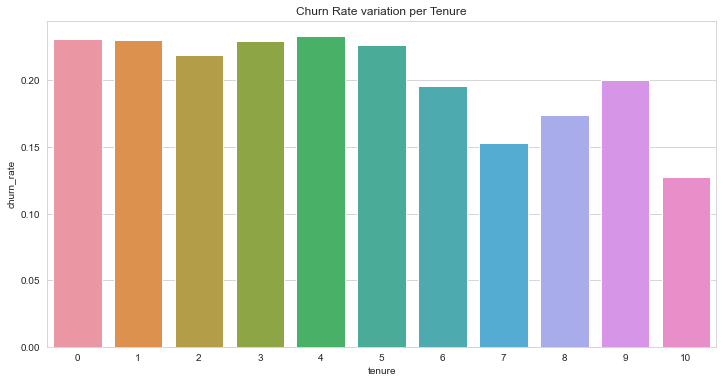

In [239]:
# plot churn rate variation per tenure
plt.figure(figsize=(12,6))
sns.barplot(x='tenure', y='churn_rate', data=churn_ten_df).set_title('Churn Rate variation per Tenure');

### 9.2.3 What's the model's performance to label the clients as churns? (Qual é o desempenho do modelo para rotular os clientes como churn?)

The model has a precision of 65.32% to label the clients as churns. The model can detect 51.84% of the clients in churn.

### 9.2.4 What's the company's revenue, if the company avoids the customers to get into churn through the developed model ? ( Qual é a receita da empresa, se a empresa evita que os clientes entrem em rotatividade através do modelo desenvolvido?)

- Bank account per client:
 - 15% for clients with estimated salary lower than the average.
 - 20% for clients with estimated salary greater than the average.

In [240]:
# calculate bank account return per client

# create auxiliary dataset
business_df = test_set.copy()

business_df['return_client'] = business_df.apply(lambda x: x['estimated_salary']*0.15 
                                                 if x['estimated_salary'] < business_df['estimated_salary'].mean() 
                                                 else x['estimated_salary']*0.2, axis=1)

* Calculate current total return of all clients. (Calcular o retorno total atual de todos os clientes.)

In [241]:
 # calculate current total return of all clients
return_total = business_df['return_client'].sum()
print(colored('Observation:', attrs=['bold']))
print('Total current return of all clients: {:,.2f}'.format(return_total))

Observation:
Total current return of all clients: 38,079,850.98


* Calculate revenue loss if all clients in churn leave the bank. (Calcular a perda de receita se todos os clientes em rotatividade deixarem o banco.)

In [242]:
# number of clients in churn
clients_churn = business_df['exited'].value_counts()[1]

# calculate total revenue loss
total_loss = business_df[business_df['exited']==1]['return_client'].sum()
print(colored('Observation:', attrs=['bold']))
print('Total revenue loss if all {} clients in churn leave the bank: {:,.2f}'.format(clients_churn, total_loss))

Observation:
Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97


* Calculate company's revenue, if the company avoids the customers to get into churn through the developed model. (Calcule a receita da empresa, se a empresa evitar que os clientes entrem em rotatividade através do modelo desenvolvido.)

In [244]:
# model predictions
y_pred = rfcl.predict(x_test)

# dataframe with predictions and predicted probabilities
business_df['predictions'] = y_pred
business_df['probabilities'] = y_scores

In [245]:
# filter clients in churn according model and dataset
aux = business_df[(business_df['exited']==1) & (business_df['predictions']==1)]

# number of clients to recover
clients_recover = len(aux)
# clients ratio w.r.t. total clients in churn
clients_ratio = (clients_recover / clients_churn)*100

# revenue if clients don't get in churn
revenue = aux['return_client'].sum()
# revenue ratio w.r.t. revenue loss
revenue_ratio = (revenue / total_loss)*100

print("Company's revenue if {} clients don't get into churn through the model: {:,.2f}".\
      format(clients_recover, revenue))
print('That represents {:,.2f}% of clients labeled as in churn and {:,.2f}% of the total revenue loss.'.\
      format(clients_ratio, revenue_ratio))

Company's revenue if 211 clients don't get into churn through the model: 4,106,314.45
That represents 51.84% of clients labeled as in churn and 54.81% of the total revenue loss.


A receita da empresa se 211 clientes não entrarem em rotatividade através do modelo: 4,190,542.16.
Isso representa 51,84% dos clientes rotulados como em churn e 55,93% da perda de receita total.

* Sort Customers according model's churn probability predictions (Ordenar os clientes de acordo com as previsões de probabilidade de rotatividade do modelo.)

In [246]:
# sort business_df according predicted probabilities
business_df = business_df.sort_values('probabilities', ascending=False)

In [247]:
business_df

credit_score geography  gender  age  tenure    balance  num_of_products  \
1521           565   Germany  Female   58       3  108888.24                3   
647            505     Spain  Female   45       9  131355.30                3   
248            469   Germany  Female   52       8  139493.25                3   
927            607    France  Female   48       4  112070.86                3   
750            556    France  Female   43       6       0.00                3   
1788           611    France  Female   61       3  131583.59                4   
1853           610     Spain  Female   50       5  130554.51                3   
1319           783   Germany  Female   58       3  127539.30                1   
338            834   Germany  Female   57       8  112281.60                3   
1747           569     Spain  Female   51       3       0.00                3   
1947           794   Germany    Male   57       3  117056.46                1   
1085           714    France  Female   51       4   88308.87                3   
882            758    France  Female   50       2   95813.76                3   
723            584   Germany  Female   37      10  134171.80                4   
46             617     Spain    Male   61       3  113858.95                1   
49             642    France    Male   48       9  118317.27                4   
1075           598    France  Female   43       5       0.00                3   
854            675    France  Female   61       5   62055.17                3   
94             555    France  Female   44       3  105770.70                3   
1298           590     Spain  Female   51       3  154962.99                3   
1490           754   Germany  Female   55       3  161608.81                1   
506            576    France  Female   55       6   44582.07                3   
586            547   Germany    Male   55       4  111362.76                3   
10             699   Germany  Female   54       3  111009.32                1   
860            727   Germany    Male   46       3  115248.11                4   
1374           468    France  Female   56      10       0.00                3   
1146           762   Germany    Male   56      10  100260.88                3   
875            669    France    Male   50       4  149713.61                3   
74             575   Germany    Male   49       7  121205.15                4   
466            555   Germany  Female   62      10  114822.64                1   
1617           587     Spain    Male   62       7  121286.27                1   
501            738   Germany    Male   58       2  133745.44                4   
1942           788   Germany  Female   49       4  137455.99                1   
1059           629   Germany  Female   45       7  129818.39                3   
262            621   Germany    Male   51       4  109978.83                1   
285            726    France  Female   53       1  113537.73                1   
1275           850   Germany    Male   43       0  108508.82                3   
1889           724     Spain  Female   41       4  142880.28                3   
1585           670   Germany    Male   40       2  164948.98                3   
163            771     Spain    Male   51       5  135506.58                3   
852            604    France  Female   53       2  121389.78                1   
1381           690   Germany  Female   54       1  144027.80                1   
1396           635   Germany  Female   65       5  117325.54                1   
1974           568   Germany    Male   43       5   87612.64                4   
1622           789   Germany    Male   51       3  104677.09                1   
484            705   Germany  Female   56       2  143249.67                1   
790            727   Germany    Male   59       5  152581.06                1   
1174           765    France  Female   56       1       0.00                1   
1224           596     Spain    Male 

## 9.3 Customers Incentive to Maximize ROI 

Quais clientes poderiam receber um incentivo e a que custo, a fim de maximizar o ROI (Return on Investment)? (a soma dos incentivos não deve exceder 10.000 euros ?

**Alternative 1: Top 100 customers with highest churn probability.**

- If churn (exited) is True, then returns revenue per customer (LTV)
- If churn (exited) is False, then returns negative revenue per customer.
- Incentive per client: \$ 100.

In [ ]:
# select top 100 clients with highest churn probability
clients_top_100 = business_df.iloc[:100]

# set incentive per client
clients_top_100['incentive'] = 100

# calculate LTV per client
clients_top_100['LTV'] = clients_top_100.apply(lambda x: x['return_client'] if x['exited']==1 
                                               else x['return_client']*-1, axis=1)
# calculate revenue
revenue = clients_top_100['LTV'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue/ total_loss)*100

# calculate the amount of investiments (sum of incentives)
investiment = clients_top_100['incentive'].sum()


# calculate ROI
roi = ((revenue - investiment)/investiment)*100

# calculate possible churn reduction in %
churn_model = clients_top_100[(clients_top_100['exited']==1) & (clients_top_100['predictions']==1)]
churn_red = (len(churn_model)/len(business_df[business_df['exited']==1]))*100

print('Revenue: {:,.2f}'.format(revenue))
print('Revenue loss recovered : {:,.2f}%'.format(loss_recovered))
print('Investiment: {:,.2f}'.format(investiment))
print('ROI: {:,.2f}'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

**Alternative 2: Top 200 customers with highest churn probability.**

- Incentive per client: $50.
- If churn (exited) is True, then returns recovered revenue per client.
- If churn (exited) is False, then returns zero.
- The profit is the difference between recovered revenue and the incentive per client

**Alternative 3: Maximum returned value with "0-1 Knapsack-Problem" Approach**

- Goal: select the optimal combination of clients that maximize the total returned value , without exceeding the total weight constraint.
- In this case, each client has a "weight": the financial incentive that will be given in order to avoid the churn.
- The total weight constraint is the total amount available to give the incentives: $ 10,000.00.
- The incentive can either be offered or not: 0-1 (0-1 Knapsack).

- Please see 0.2. Helper Functions section for knapsack function details.